# **Perkenalan**

'''
=================================================
Graded Challenge 5

Nama  : Desvin Sitohang
Batch : MSIB-06 (RMT-029)

Ini adalah Machine Learning klasifikasi yang dirancang untuk untuk memprediksi biaya pembayaran untuk bulan berikutnya berdasarkan kolom fitur yang diberikan menggunakan regresi logistik, SVM, dan KNN.
=================================================
'''

#  **Query SQL**

### Setelah di hubungkan, selanjutnya kita bisa memanggit database

#Memanggil database dan mendeskripsikannya menjadi dataframe
credit_card_database = client.query('''SELECT limit_balance, CAST(sex AS INT64) AS sex, CAST(education_level AS INT64) AS education_level, CAST(marital_status AS INT64) AS marital_status,
age, pay_0, pay_2, pay_3, pay_4, CAST(pay_5 AS FLOAT64) AS pay_5, CAST(pay_6 AS FLOAT64) AS pay_6, bill_amt_1, bill_amt_2, bill_amt_3,
bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM  bigquery-public-data.ml_datasets.credit_card_default
''').to_dataframe()
print(credit_card_database)

### Data selesai diambil dari big query, selanjutnya kita akan import menjadi .csv langsung di big querry

# **Import Libraries**

In [2]:
#Menganalisis data
import pandas as pd

#Melakukan pengolahan angka
import numpy as np

#Membuat visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify
import squarify

#Feature Selection
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

#preposesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler

#Penanganan Outlier
!pip install feature-engine
from feature_engine.outliers import Winsorizer

#pemodelan ml
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Untuk Model Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Model Tunning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#save model
import pickle
import joblib
import json

# **Data Loading**

#### Pertama kita akan load data dari data yang sudah di import dari big query tadi

In [51]:
df = pd.read_csv('P1G5_Set_1_Desvin_Sitohang.csv')

#### Kemudian kita akan melihat nilai awal dan nilai akhir dari data

In [52]:
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000,1,6,1,54,0,0,0,0,0,...,29296,26210,17643,2545,2208,1336,2232,542,348,1
1,200000,1,4,1,49,0,0,0,0,0,...,50146,50235,48984,1689,2164,2500,3480,2500,3000,0
2,20000,2,6,2,22,0,0,0,0,0,...,1434,500,0,4641,1019,900,0,1500,0,1
3,260000,2,4,2,33,0,0,0,0,0,...,27821,30767,29890,5000,5000,1137,5000,1085,5000,0
4,150000,1,4,2,32,0,0,0,-1,0,...,150464,143375,146411,4019,146896,157436,4600,4709,5600,0


In [53]:
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,80000,2,3,2,28,-1,-1,-1,-2,-2,...,0,0,0,2800,0,0,0,0,0,0
2961,50000,2,3,1,51,-1,-1,-1,-1,-2,...,0,0,0,300,5880,0,0,0,0,1
2962,450000,2,2,1,38,-2,-2,-2,-2,-2,...,390,390,390,390,780,390,390,390,390,1
2963,50000,2,2,1,44,-2,-2,-2,-2,-2,...,390,390,0,390,390,390,390,0,780,0
2964,290000,2,2,1,39,1,-2,-2,-2,-2,...,3184,390,390,10000,800,3184,390,390,6617,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

#### Pada dataset diketahui bahwa:
- Memiliki 24 kolom
- Memiliki 2.965 baris
- Kolom id merupakan kolom penanda untuk dataset ini
- Kolom predicted_default_payment_next_month merupakan hasil predicted yang dilakukan sebelemnya pada dataset ini
- Nampak semua tipe data kolom sudah sesuai dengan nilainya masing-masing

# **EDA**

### Diketahui bahwa data merupakan nilai dari credit card yang berisikan :
- Data diri pengguna
- History dari pembayaran terdahulu
- Jumlah tagihan
- dan apakah ada tagihan untuk bulan depan atau tidak

#### Pertama kita akan melihat ringkasan nilai statistika deskriptif dari datanya

In [68]:
df.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


#### Dari hasil analisis statistik deskriptif dari data, deketahui bahwa:
- Sebagian besar dari kolom pada data memiliki nilai rata-rata dan median yang cukup jauh berbeda sehingga diasumsikan bahwa sebagian besar kolom pada data berdistribusi skew
- diketahui juga bahwa kisaran atau rentang nilai dari data memiliki nilai jang jauh berbeda sehingga perlu discalling pada feature engineering nanti

##### Dari hasil data loading diketahui bahwa seiap user memiliki limit balance (Jumlah kredit yang diberikan dalam dolar NT) dan juga memiliki education level sehingga kita akan lihat bagaimana sebaran limit balance berdasarkan education level menggunakan scatter plot

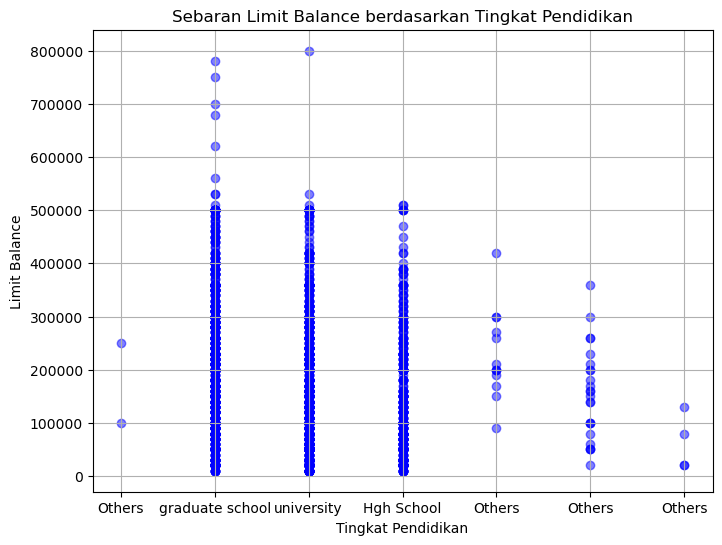

In [58]:
# Membuat scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['education_level'], df['limit_balance'], color='blue', alpha=0.5)
plt.title('Sebaran Limit Balance berdasarkan Tingkat Pendidikan')
plt.xlabel('Tingkat Pendidikan')
plt.ylabel('Limit Balance')
plt.xticks([1, 2, 3, 4, 5, 6, 0], ['graduate school', 'university', 'Hgh School', 'Others', "Others", 'Others', "Others"])  # Label sumbu x
plt.grid(True)
plt.show()

Saldo limit kredit tertinggi dimiliki oleh orang-orang dengan tingkat pendidikan universitas, diikuti oleh orang telah lulus sekolah, sekolah menengah atas, dan kemudian lainnya. Ini menunjukkan bahwa orang dengan tingkat pendidikan lebih tinggi cenderung memiliki saldo limit kredit yang lebih tinggi.

Ada beberapa kemungkinan penjelasan untuk hal ini. Orang dengan tingkat pendidikan lebih tinggi mungkin lebih mungkin mendapatkan pekerjaan dengan gaji lebih tinggi, yang memungkinkan mereka untuk memenuhi syarat limit kredit yang lebih tinggi. Mereka mungkin juga lebih mungkin disetujui untuk mendapatkan kartu kredit dengan program reward yang lebih baik, yang dapat membuat mereka menghabiskan lebih banyak uang menggunakan kartunya.

penting juga untuk dicatat bahwa plot ini tidak menunjukkan informasi apapun tentang tingkat pendapatan orang dalam tiap kelompok pendidikan. Mungkin saja orang dengan tingkat pendidikan lebih tinggi kebetulan memiliki pendapatan lebih tinggi, yang memungkinkan mereka untuk memiliki saldo limit kartu kredit yang lebih tinggi.

Secara keseluruhan, plot ini menunjukkan adanya korelasi antara tingkat pendidikan dan saldo limit kredit di Indonesia. Namun, penting untuk diingat bahwa korelasi tidak sama dengan kausalitas. Mungkin ada faktor lain yang menjelaskan hubungan antara kedua variabel ini.

#### kemudian kita juga akan melihat sebaran data tagihan terakhir (bill_amt_1) yang dikurangi pembayaran terakhir (pay_amt_1)

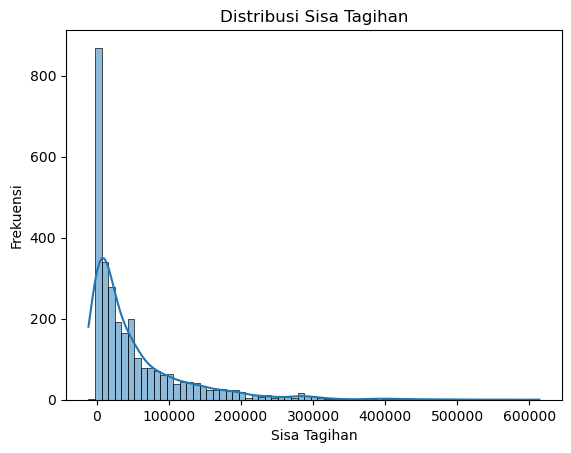

In [71]:
# Memperbarui plot menggunakan histplot
sns.histplot(df['bill_amt_1'], kde=True)
plt.title('Distribusi Sisa Tagihan')
plt.xlabel('Sisa Tagihan')
plt.ylabel('Frekuensi')
plt.show()

Dari plot diketahui bahwa:
- Mayoritas pelanggan tidak memiliki tagihan atau tagihanya bernilai 0 $. Hal ini menunjukkan bahwa banyak pelanggan yang berhasil melunasi tagihan mereka tepat waktu atau memiliki sisa tagihan yang minimal.
- Semakin tinggi nilai sisa tagihan, semakin sedikit jumlah pelanggan yang memilikinya. Ini menunjukkan bahwa sebagian besar pelanggan berusaha untuk menjaga sisa tagihan mereka tetap rendah.

### Kemudian dari hasil analisis pada nilai tagihan terakhir (bill_amt_1) memiliki nilai 0 yang banyak sehingga diasumsikan bahwa sebaran dari nilai default payment next month akan lebih banyak yang tidak harus membayar (nilai 0). namum untuk membuktikanya, kita akan melakukan plotting pada nilainya menggunakan pie chart sehingga perbandingan nilainya bisa dipahami dengan mudah

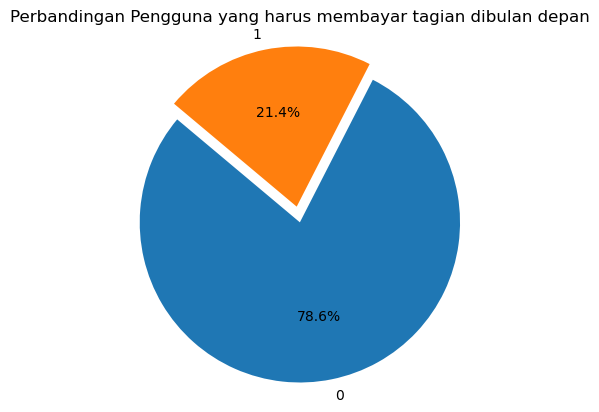

In [70]:
# Create a circle at the center of the plot
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Data
sizes = df['default_payment_next_month'].value_counts()
labels = df['default_payment_next_month'].unique().tolist()[::-1]

# Menghitung nilai untuk parameter explode
explode = [0.1 if size == sizes.max() else 0 for size in sizes]

# Plot pie chart
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Agar pie chart terlihat seperti lingkaran
plt.title('Perbandingan Pengguna yang harus membayar tagian dibulan depan')
plt.show()


#### Dari hasil analisis diketahui bahwa pengguna yang harus melakukan pembayaran tagihan dibulan depan adalah 21.4% sehingga bisa diakatakan bahwa data tidak imbang antara pengguna yang harus membayar tagihan dan yang tidak.

# **Feature Engineering**

## **Splitting Data**

### Split data dilakukan pertama kali guna menghindari data leaking dan data test tetap aman digunakan. Petama-tama kita akan mendefiniskan terlebih dahulu variabel fitur (X) dan variabel target (y)

In [9]:
#mendeskripsikan variabel X dan y
X= df.drop('default_payment_next_month', axis = 1)
y=df['default_payment_next_month']

### Setelah didefinisikan, selanjutnya kita akan pencah menjadi train dan test data

In [10]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=101, stratify=y)

spliting data ini digunakan untuk untuk melatih model pada subset train dan menguji kinerjanya pada subset test, sehingga memungkinkan evaluasi yang lebih objektif terhadap kinerja model. pada spliting kali ini, akan dibagi menjadi 20% data test dan 80% data train. kemudian digunakan  **stratify=y**, karena
 untuk memastikan bahwa kedua set data train dan data test mewakili dengan benar proporsi kelas yang sama, sehingga hasil evaluasi model tidak bias atau terpengaruh oleh ketidakseimbangan kelas dalam pembagian data. Hal ini penting
  untuk dapat membantu mencegah training model tidak memadai pada kelas minoritas karena data tidakseimbang (imbalanced).



### Kemudian akan dibuat list kolom fitur numerik dan kategori untuk memudahkan feature engineering kedepannya

In [11]:
list_cat = X_train.select_dtypes(include='object').columns.tolist() #List katergori
list_num = X_train.select_dtypes(exclude='object').columns.tolist() #List Numerik

## **Handling Outlier**

### Selanjutnya akan dilihat jumlah outlier pada setiap kolom fitur ini berdasarkan data X_train

In [12]:
# Hitung IQR
list_outlier=[]
list_lower_bound =[]
list_upper_bound =[]
for i in X_train[list_num]:
    Q1 = np.percentile(X_train[i], 25)
    Q3 = np.percentile(X_train[i], 75)
    IQR = Q3 - Q1

    # Tentukan batas bawah dan batas atas untuk outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    list_lower_bound.append(lower_bound)
    list_upper_bound.append(upper_bound)

    # Hitung jumlah outlier di bawah batas bawah dan di atas batas atas
    num_outliers_lower = np.sum(X_train[i] < lower_bound)
    num_outliers_upper = np.sum(X_train[i] > upper_bound)

    # Jumlah total outlier
    total_outliers = num_outliers_lower + num_outliers_upper
    list_outlier.append(total_outliers)

#Mendefinikan dataframe baru mengenai outliers
outliers = pd.DataFrame()
outliers['Kolom'] = list_num
outliers['Jumlah Outlier'] = list_outlier
outliers['Lower Bound'] = list_lower_bound
outliers['Upper Bound'] = list_upper_bound
outliers

,Kolom,Jumlah Outlier,Lower Bound,Upper Bound
0,limit_balance,11,-220000.000,500000.000
1,sex,0,-0.500,3.500
2,education_level,30,-0.500,3.500
3,marital_status,0,-0.500,3.500
4,age,24,8.500,60.500
5,pay_0,239,-2.500,1.500
6,pay_2,339,-2.500,1.500
7,pay_3,322,-2.500,1.500
8,pay_4,279,-2.500,1.500
9,pay_5,249,-2.500,1.500


### Dari hasil analisa diketahui bahwa 20 kolom fitur memiliki outlier pada data dengan jumlah yang berbeda-beda. namun karena model yang akan digunakan kali ini sangat sensitif terhadap outlier(KNN dan SVM) sehingga outlier yang ada pada data selanjutnya akan di handling semua

### Kemudian akan dilihat sebaran setiap kolom numerik untuk mengetahui metode handling value seperti apa yang akan dilakukan

In [13]:
#mendefinisikan kolom yang digunakan dan list tempat value skewness
df_num = X_train[list_num]
nilai_skew = []
nilai_skew_normal = []

#membuat fungsi untuk memetakan distribusi setiap kolom
for i in df_num.columns:
    skewness = X_train[i].skew()
    if -0.5 <= skewness <= 0.5:
        nilai_skew_normal.append(i)
    else:
        nilai_skew.append(i)

# Menampilkan list
print('kolom yang mempunyai nilai skewness sedang:', nilai_skew)
print('kolom yang mempunyai nilai skewness normal:', nilai_skew_normal)

kolom yang mempunyai nilai skewness sedang: ['limit_balance', 'education_level', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
kolom yang mempunyai nilai skewness normal: ['sex', 'marital_status']


### Setelah dilihat sebaran datanya, diketahui bahwa seluruh kolom fitur kecuali sex dan marital_status berdistribusi skew

In [14]:
int_kolom = ['education_level']  # Ganti 'kolom1', 'kolom2', ... dengan nama kolom Anda
X_train[int_kolom] = X_train[int_kolom].astype(float)
X_test[int_kolom] = X_test[int_kolom].astype(float)

#Penanganan outlier menggunakan metode capping dengan Winsorizer untuk kolom skew
winsoriserskew = Winsorizer(capping_method='iqr', #For skewed distribution
                            tail='both',
                            fold=1.5,
                            variables= nilai_skew,      #Target columns
                            missing_values='ignore')

X_train_capped = winsoriserskew.fit_transform(X_train)
X_test_capped = winsoriserskew.transform(X_test)

### Setelah selesai dihandling, kemudian akan dilihat sebaran sesudah dan sebelum dihandling menggunakan histogram dan boxplot untuk setiap kolom fitur

In [15]:
#Defining a function to create histogram and box plot for certain variables
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(10, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, color='teal')
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable], color='teal')
    plt.title('Boxplot')

    plt.show()

limit_balance - Before Capping


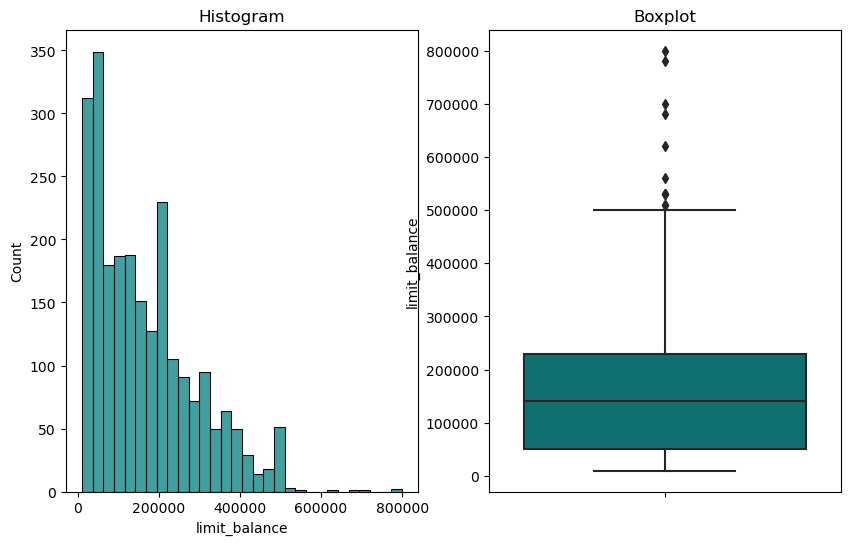


limit_balance - After Capping


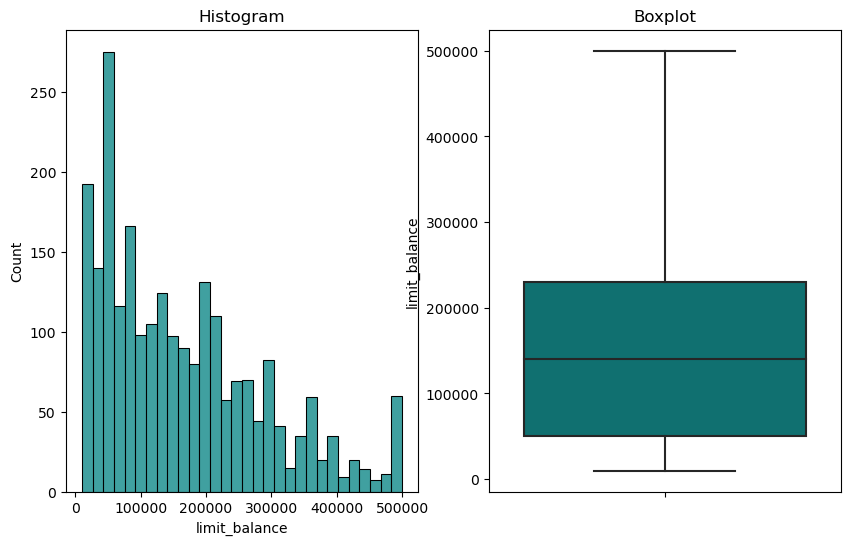

sex - Before Capping


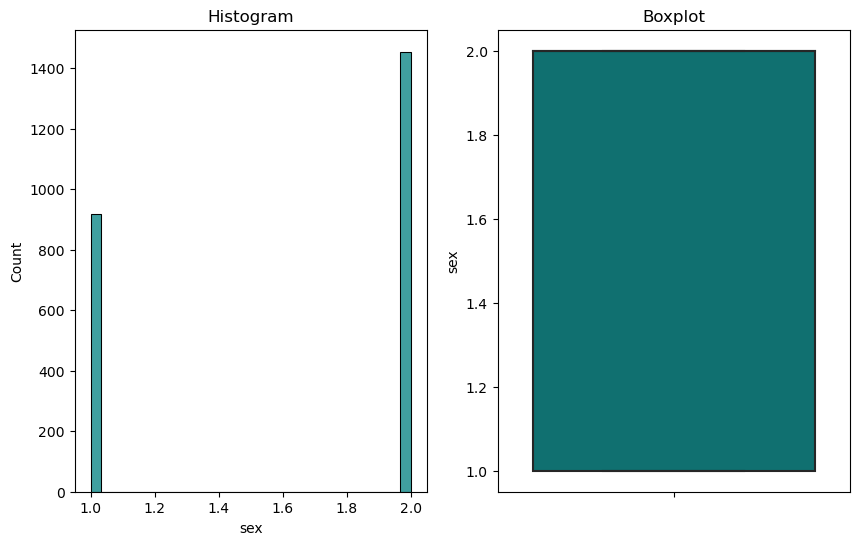


sex - After Capping


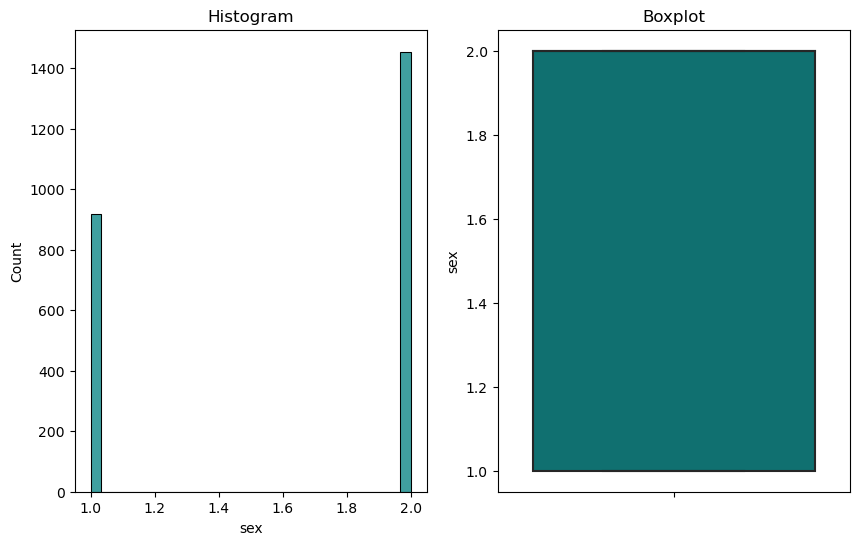

education_level - Before Capping


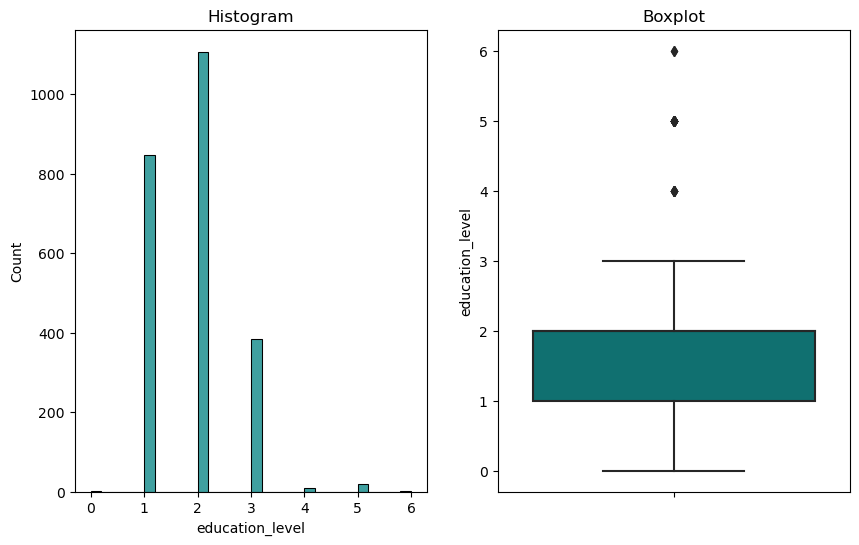


education_level - After Capping


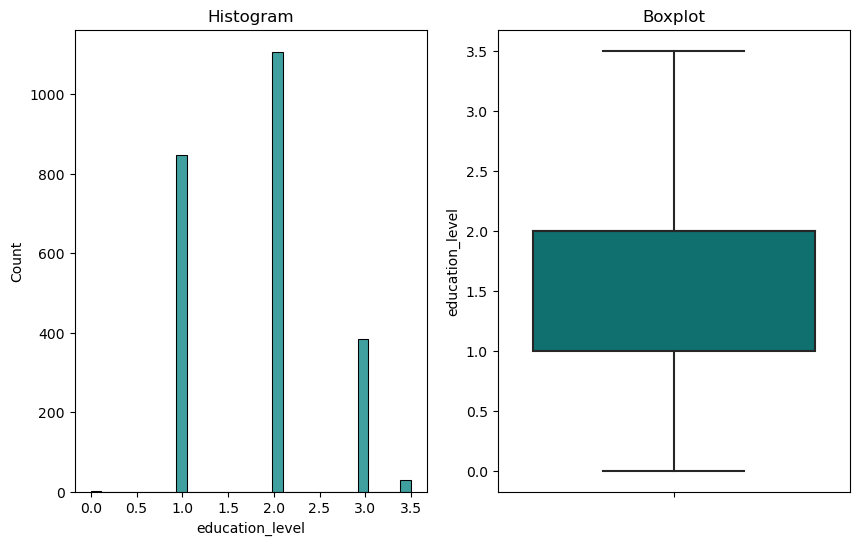

marital_status - Before Capping


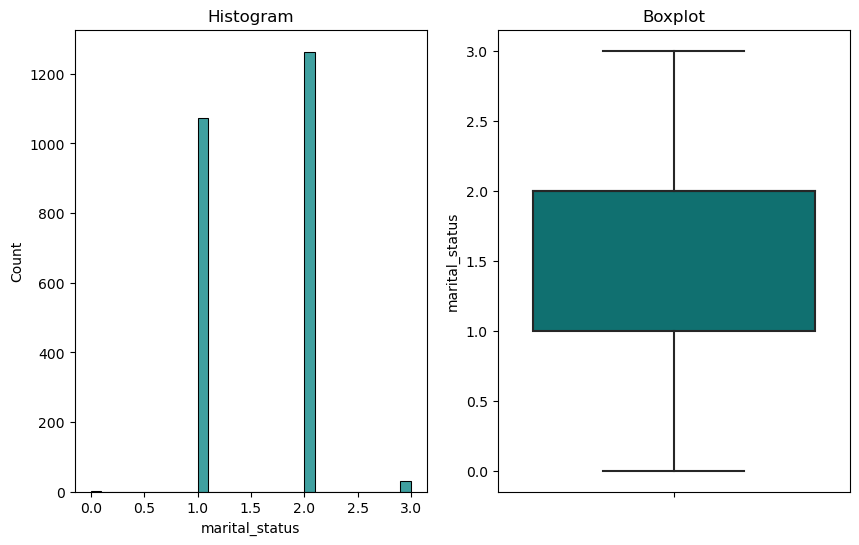


marital_status - After Capping


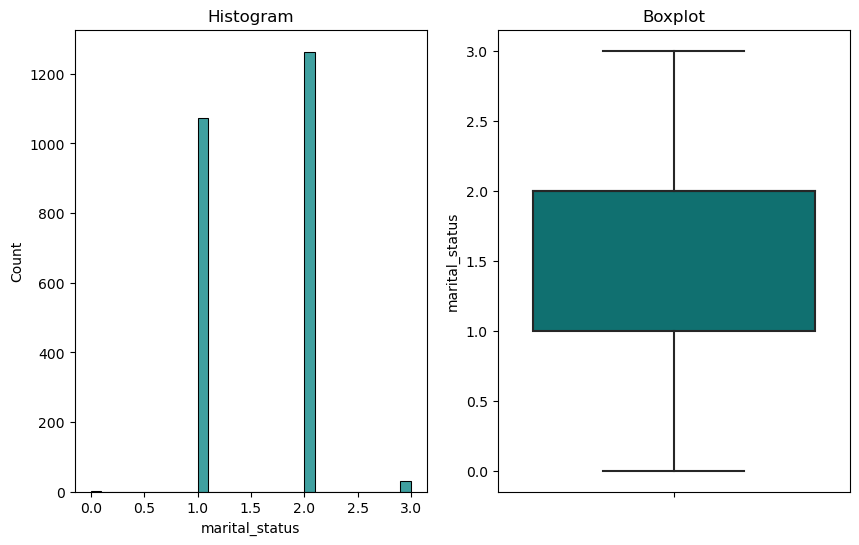

age - Before Capping


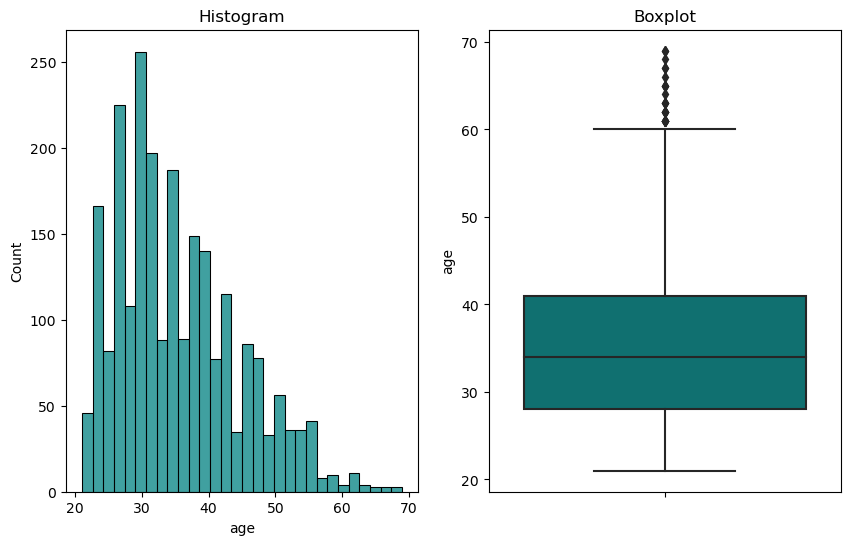


age - After Capping


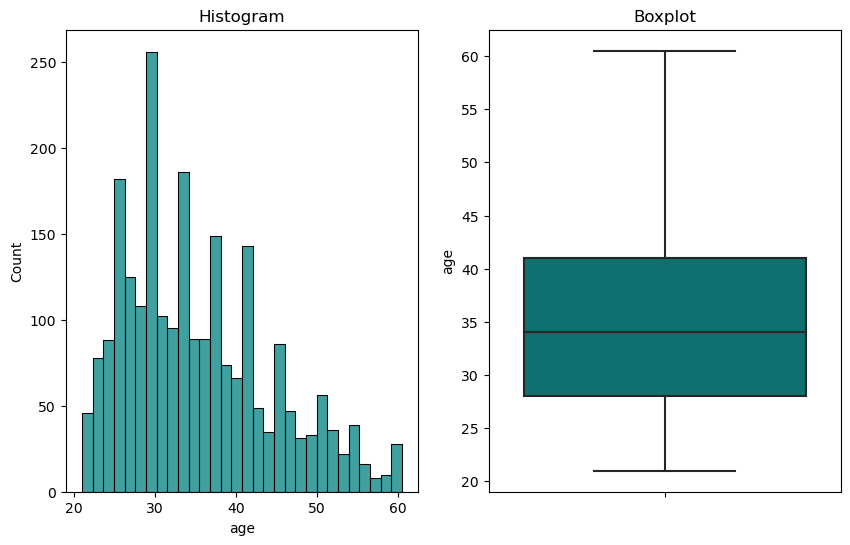

pay_0 - Before Capping


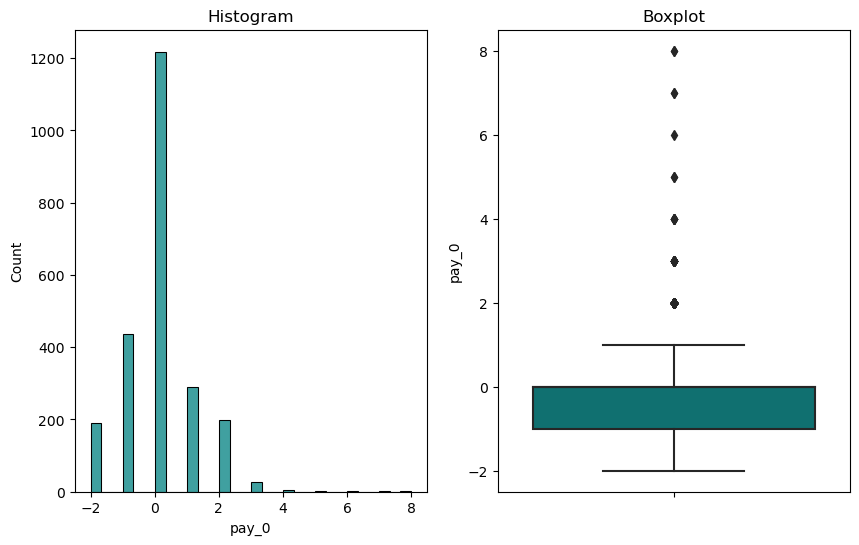


pay_0 - After Capping


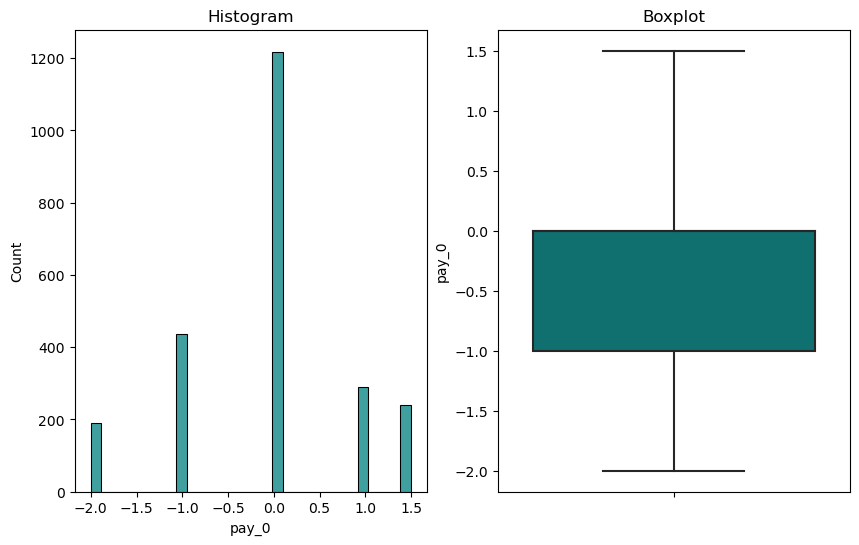

pay_2 - Before Capping


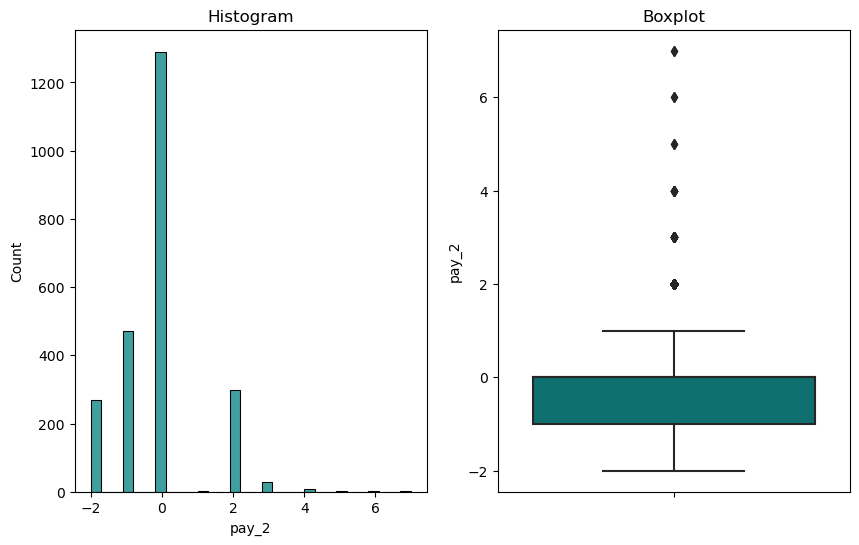


pay_2 - After Capping


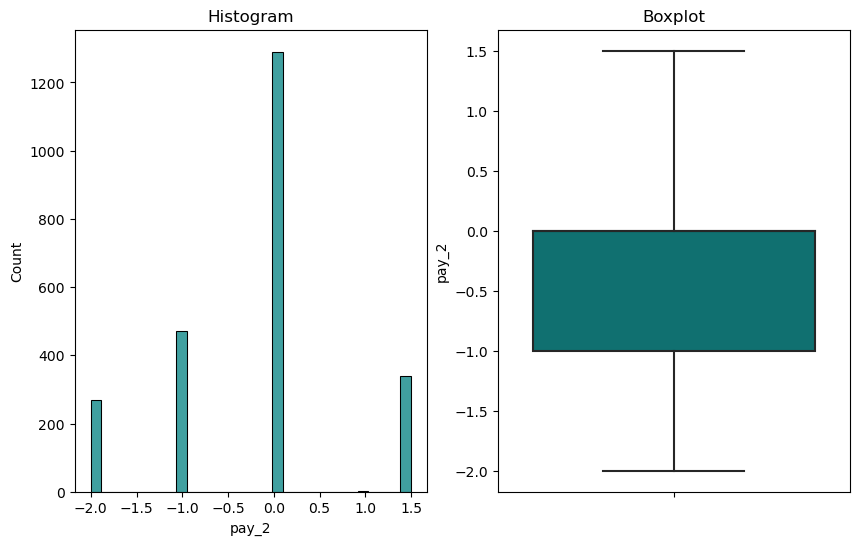

pay_3 - Before Capping


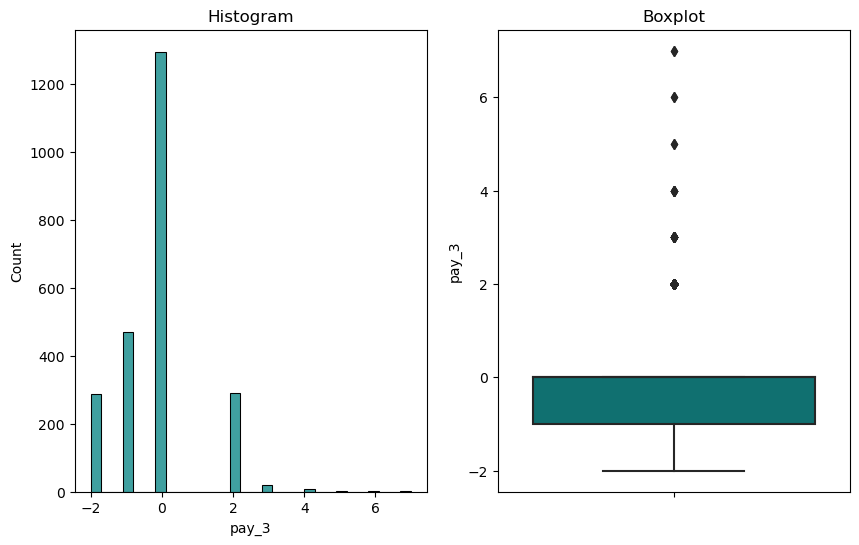


pay_3 - After Capping


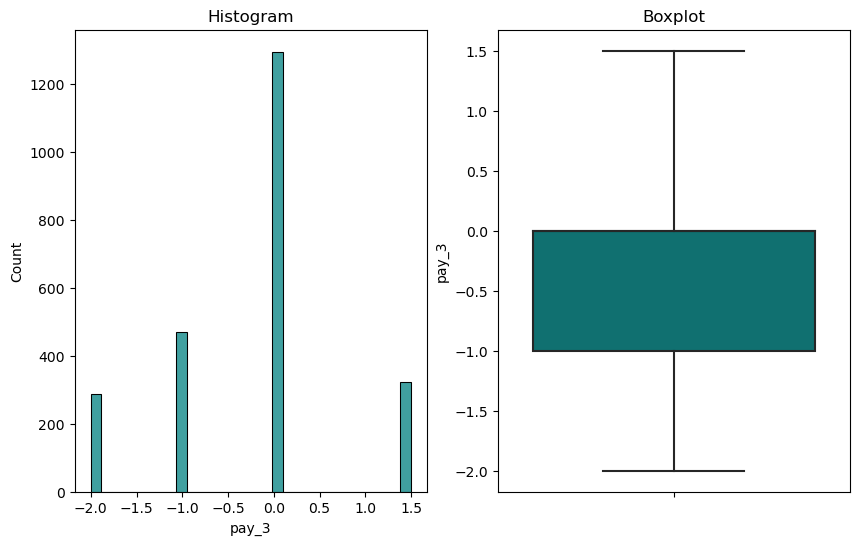

pay_4 - Before Capping


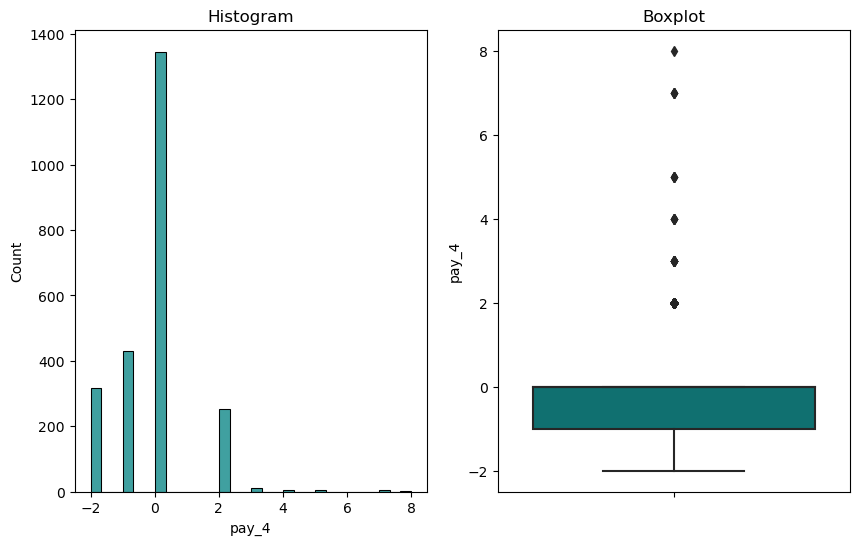


pay_4 - After Capping


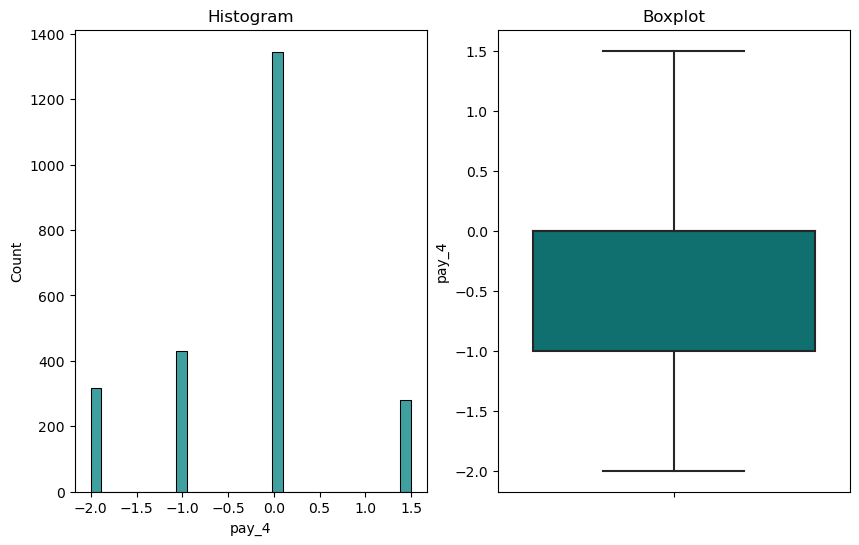

pay_5 - Before Capping


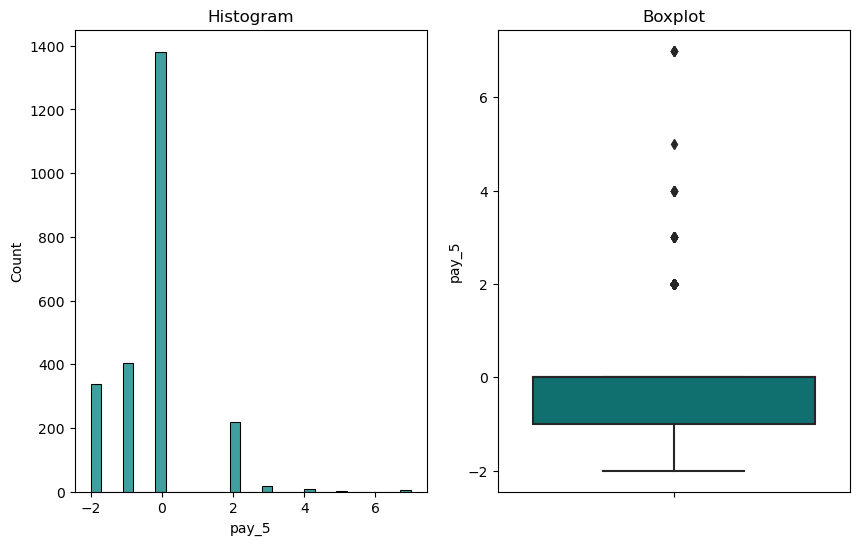


pay_5 - After Capping


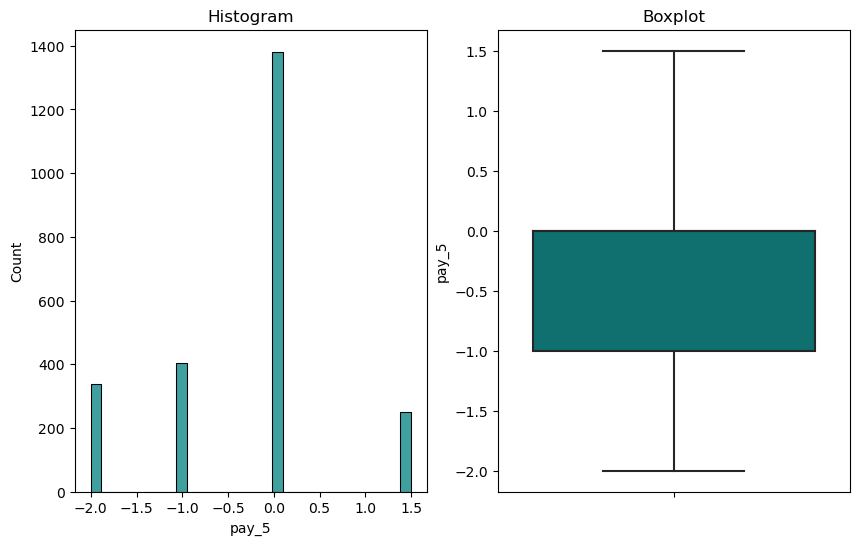

pay_6 - Before Capping


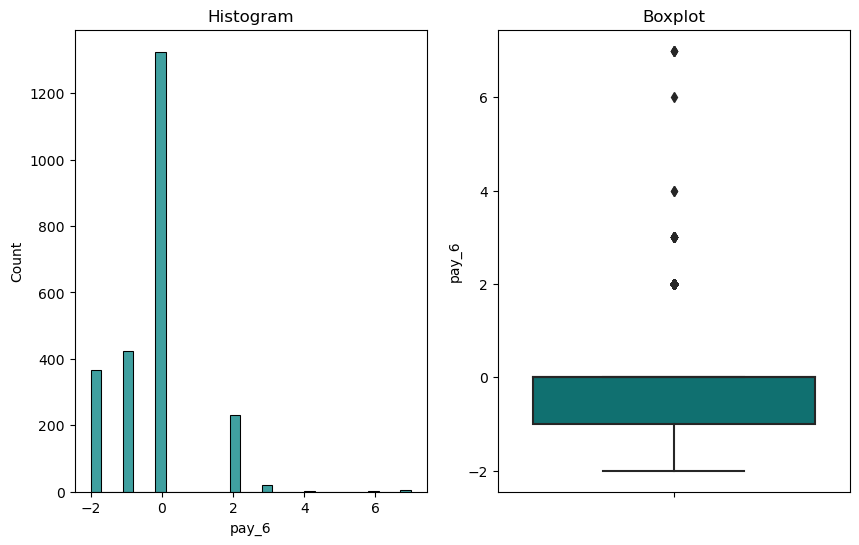


pay_6 - After Capping


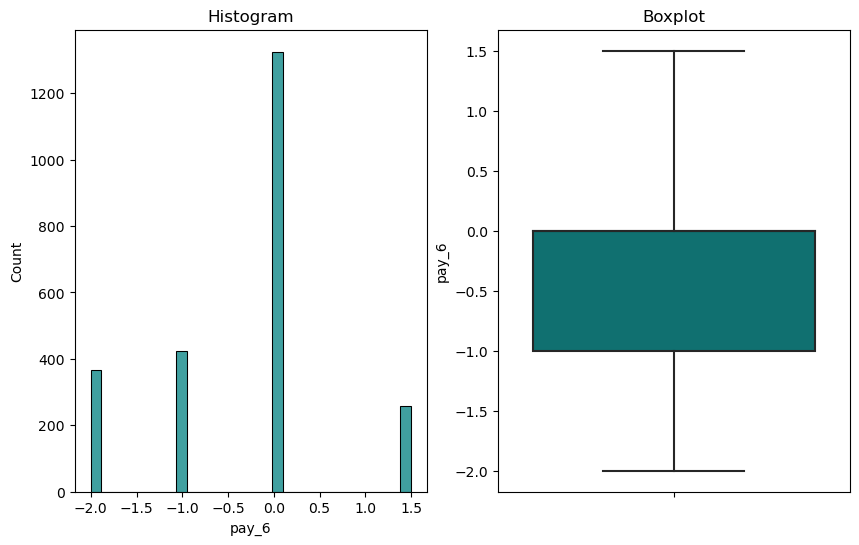

bill_amt_1 - Before Capping


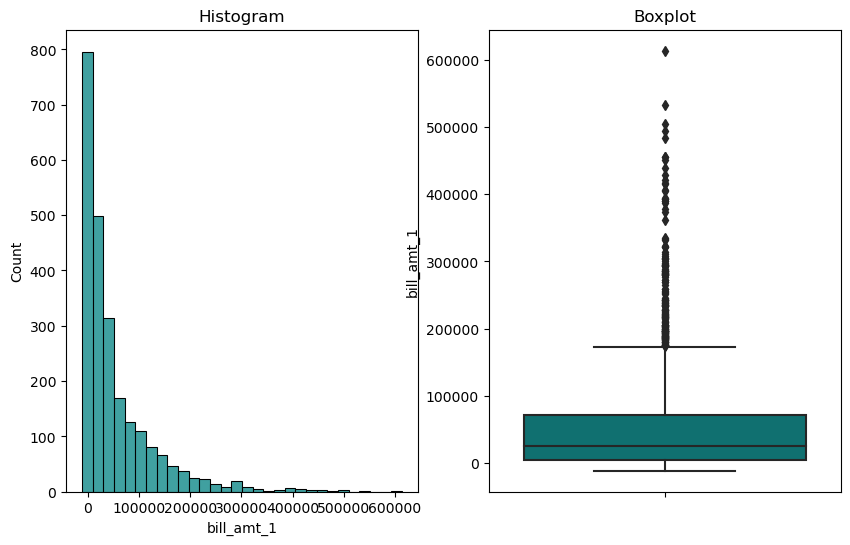


bill_amt_1 - After Capping


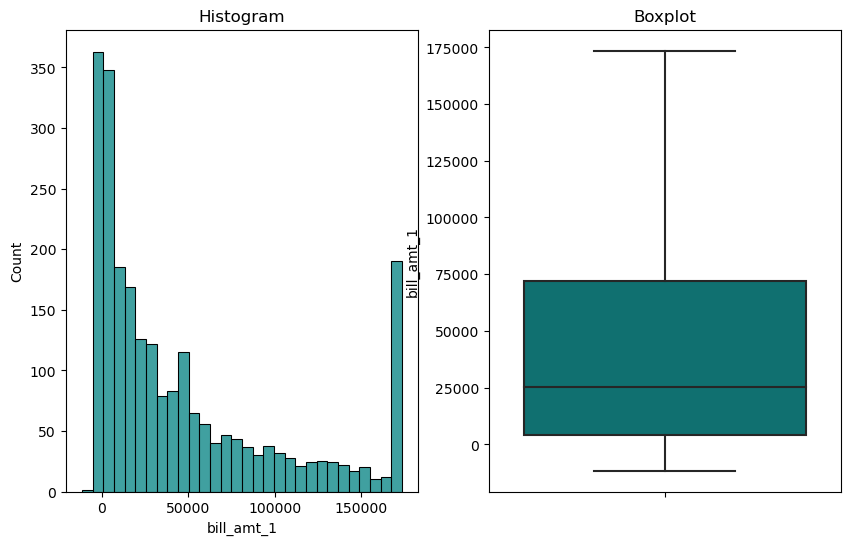

bill_amt_2 - Before Capping


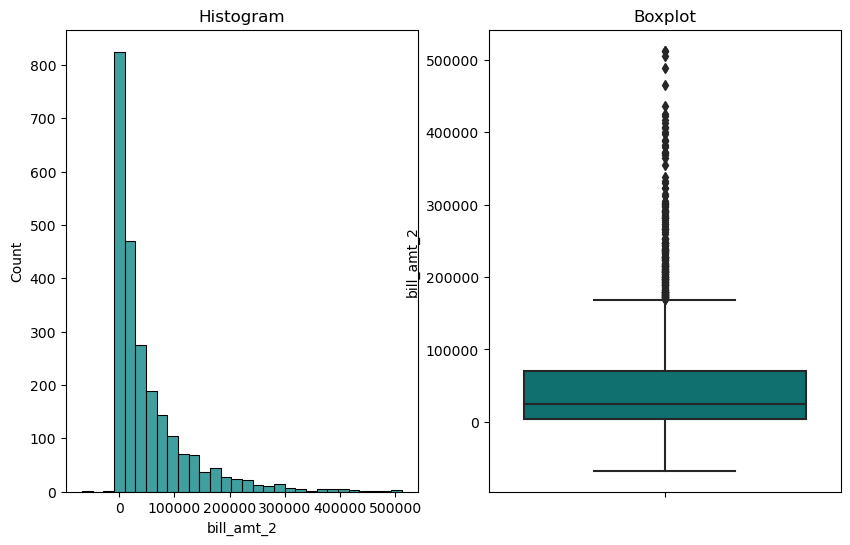


bill_amt_2 - After Capping


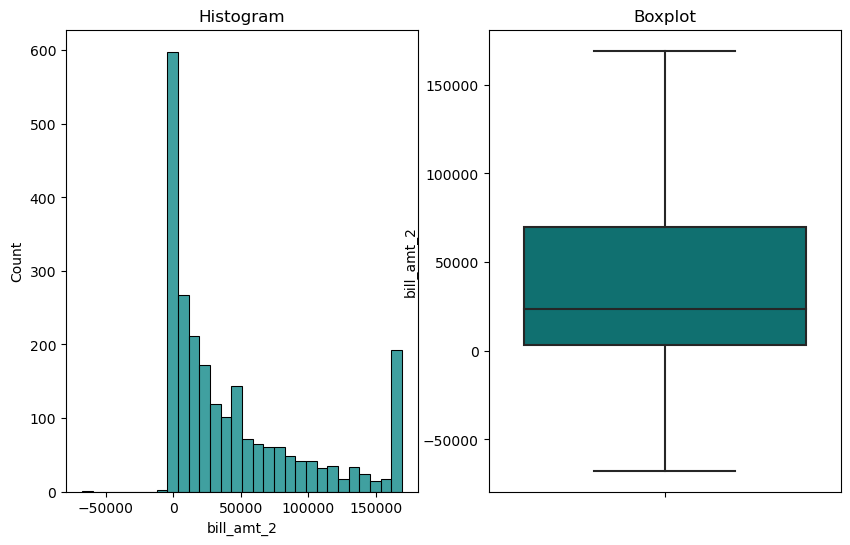

bill_amt_3 - Before Capping


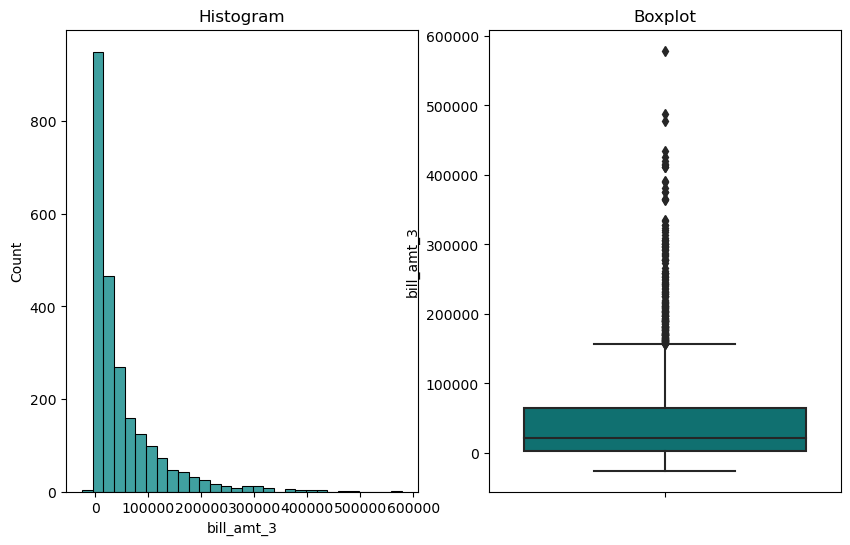


bill_amt_3 - After Capping


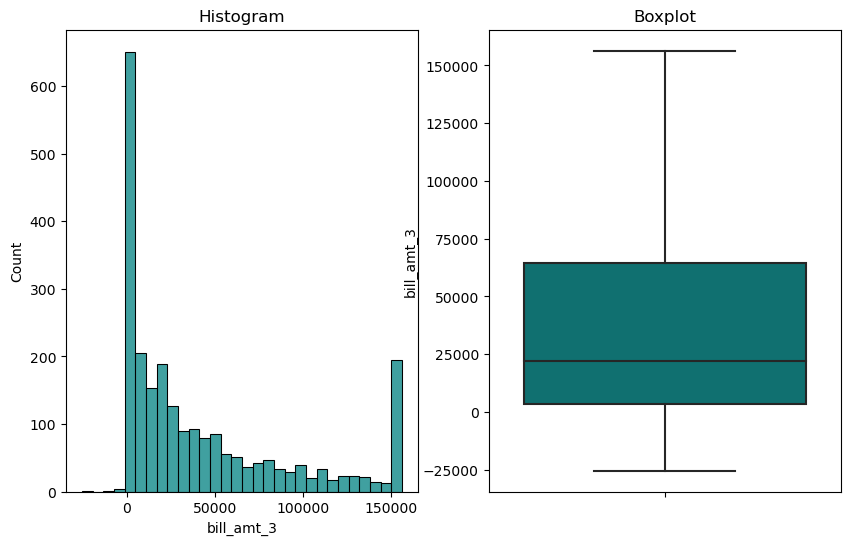

bill_amt_4 - Before Capping


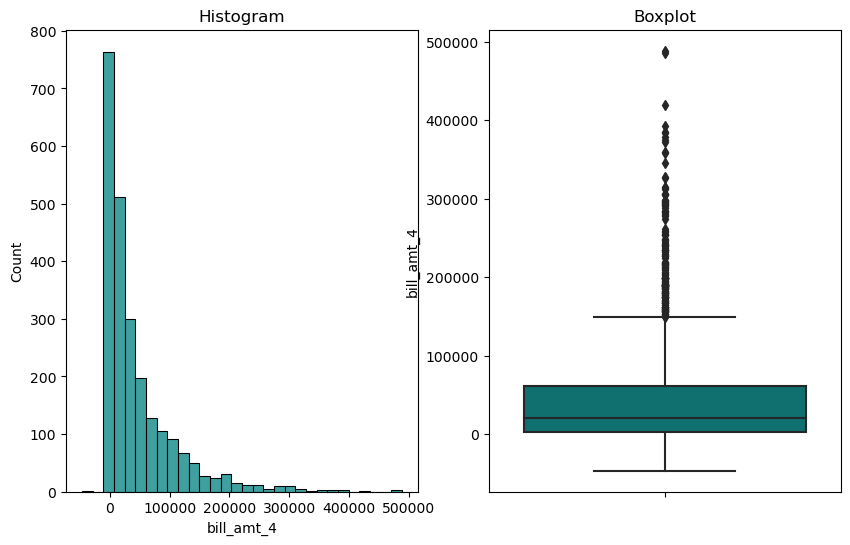


bill_amt_4 - After Capping


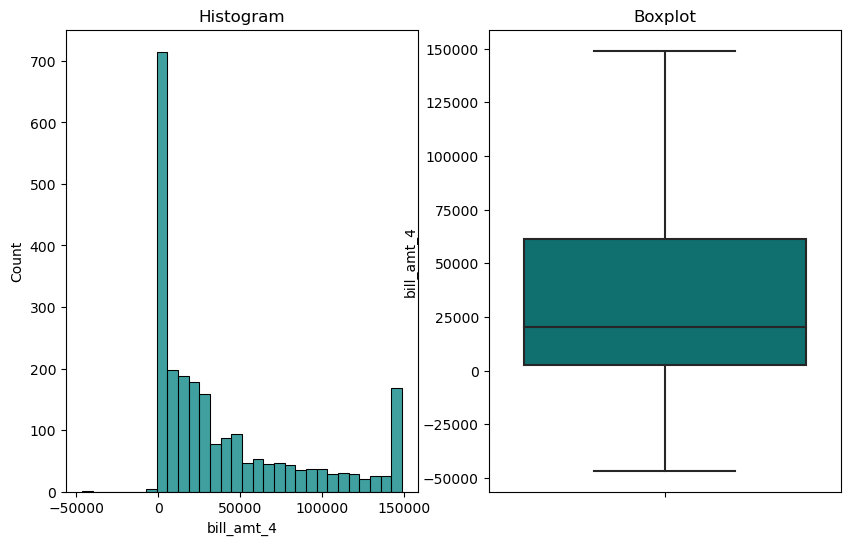

bill_amt_5 - Before Capping


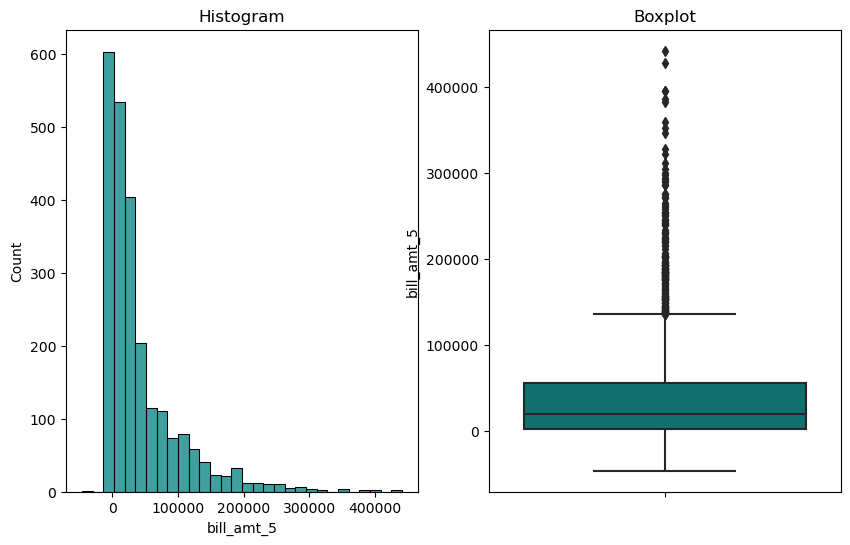


bill_amt_5 - After Capping


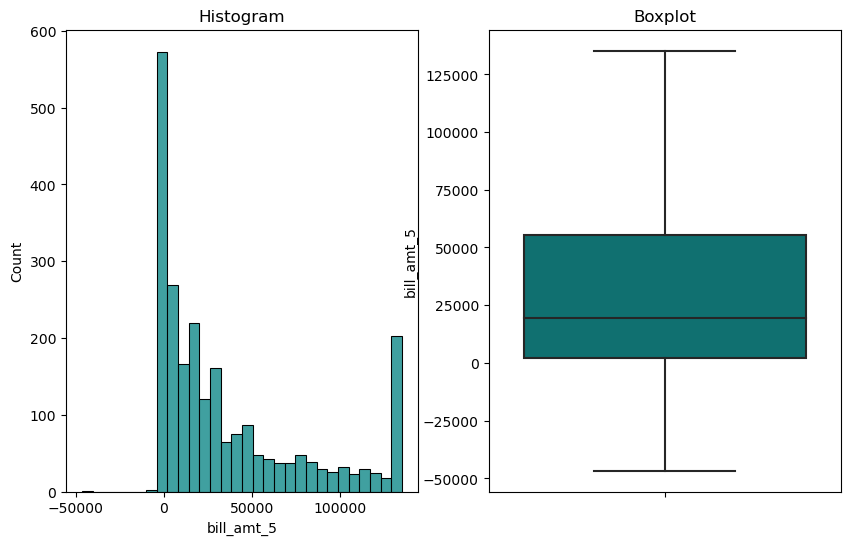

bill_amt_6 - Before Capping


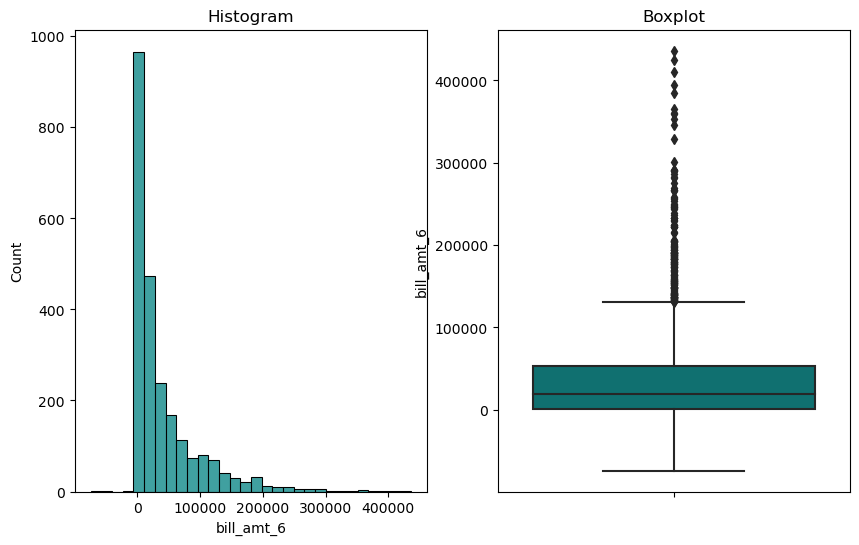


bill_amt_6 - After Capping


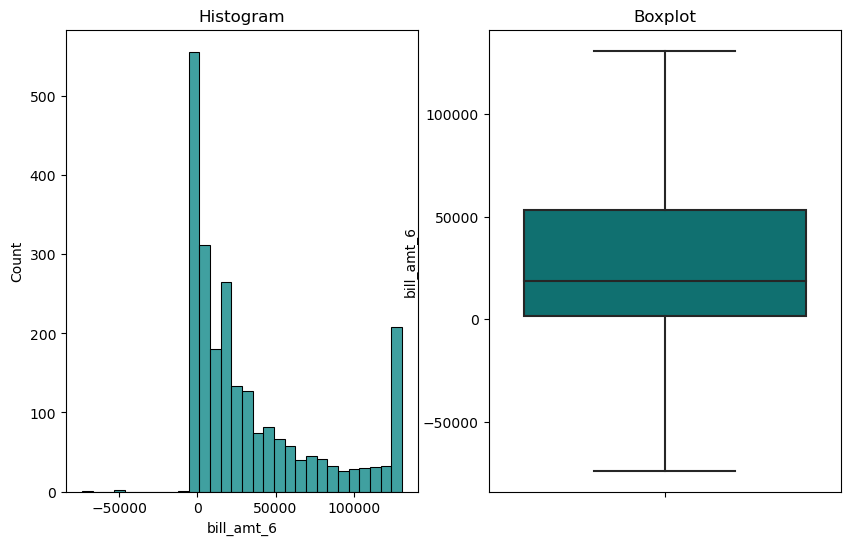

pay_amt_1 - Before Capping


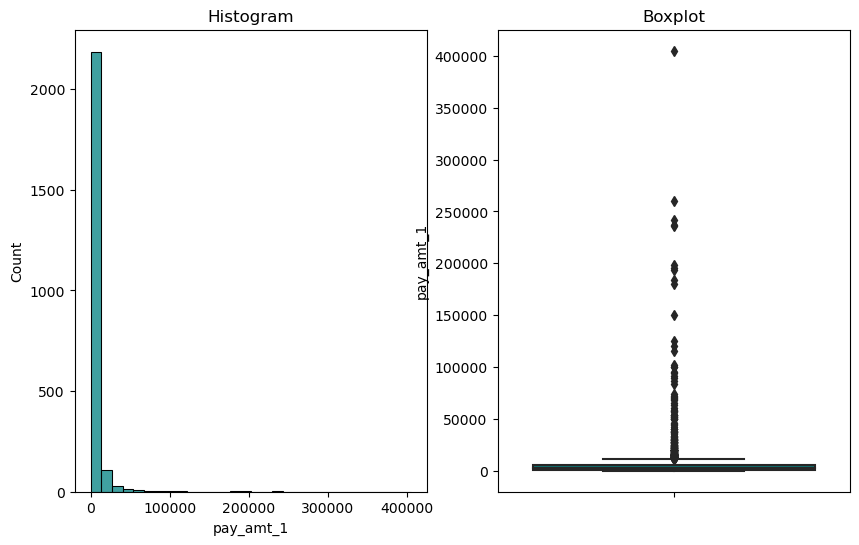


pay_amt_1 - After Capping


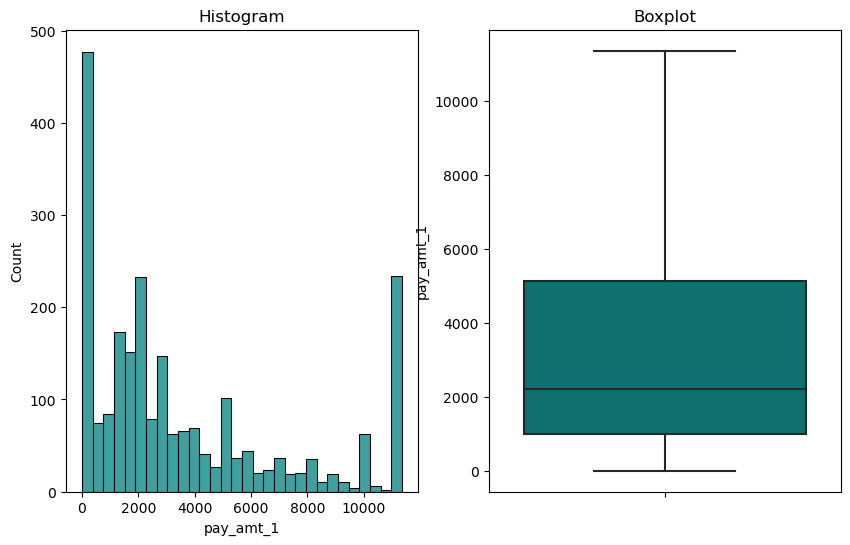

pay_amt_2 - Before Capping


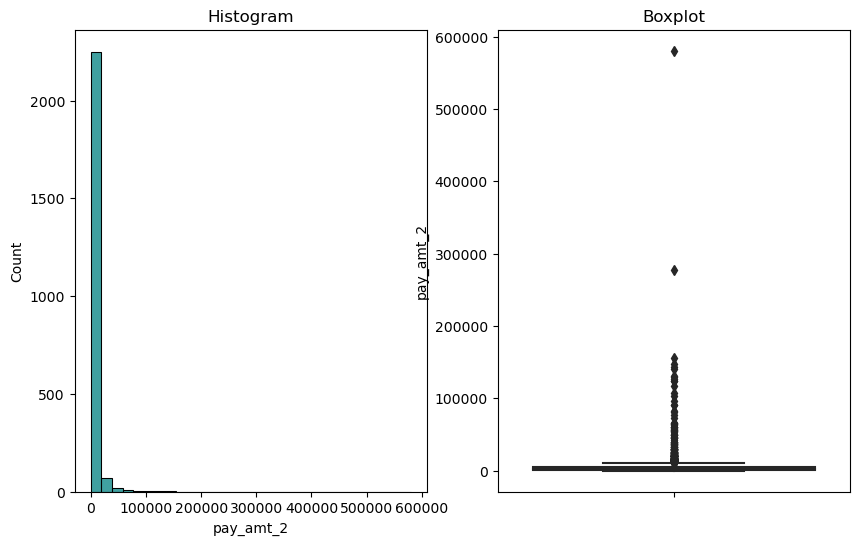


pay_amt_2 - After Capping


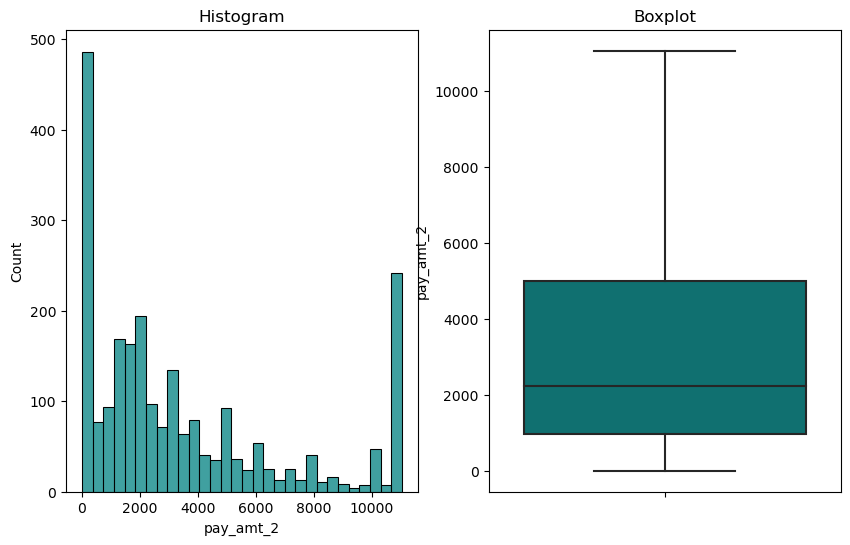

pay_amt_3 - Before Capping


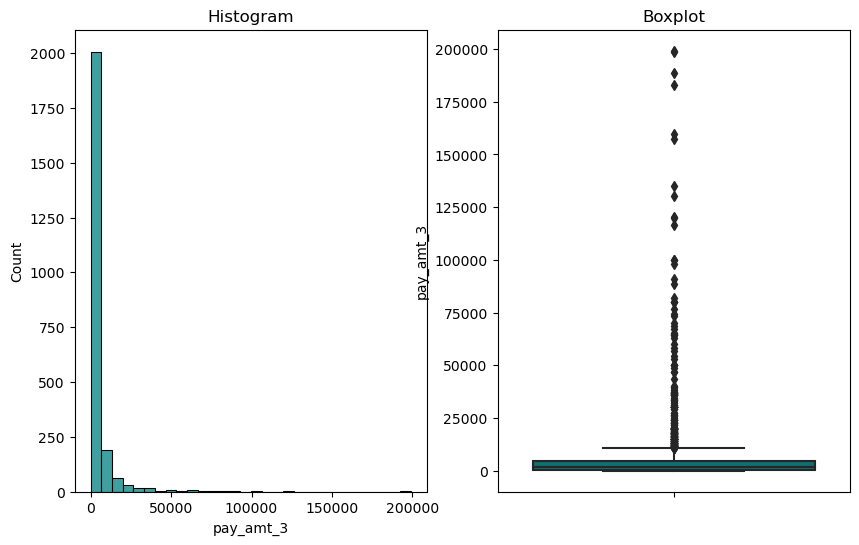


pay_amt_3 - After Capping


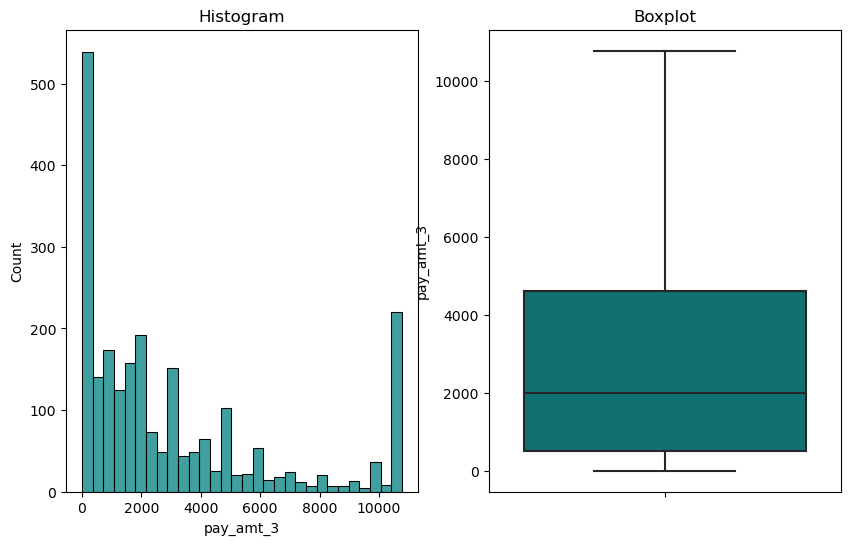

pay_amt_4 - Before Capping


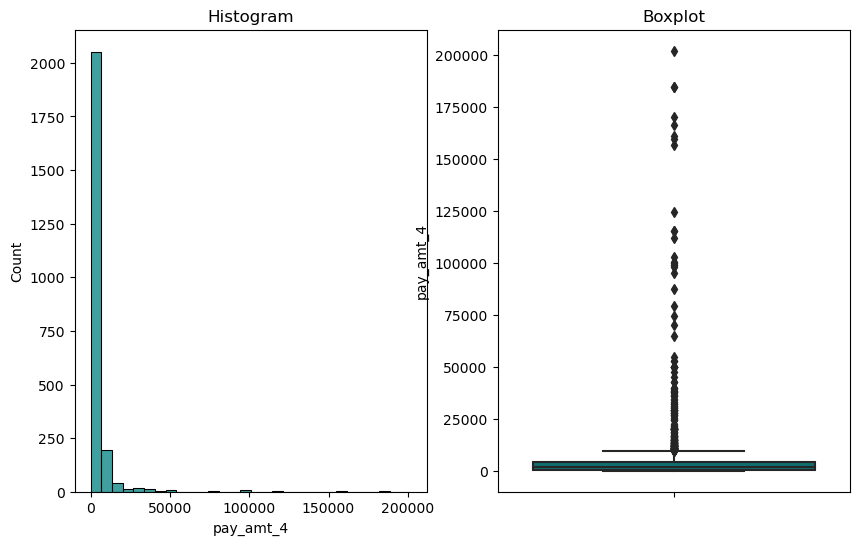


pay_amt_4 - After Capping


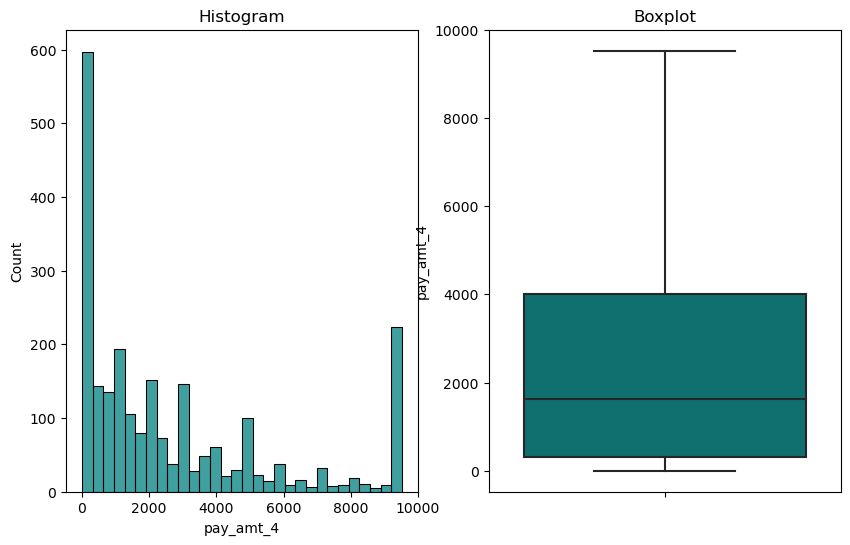

pay_amt_5 - Before Capping


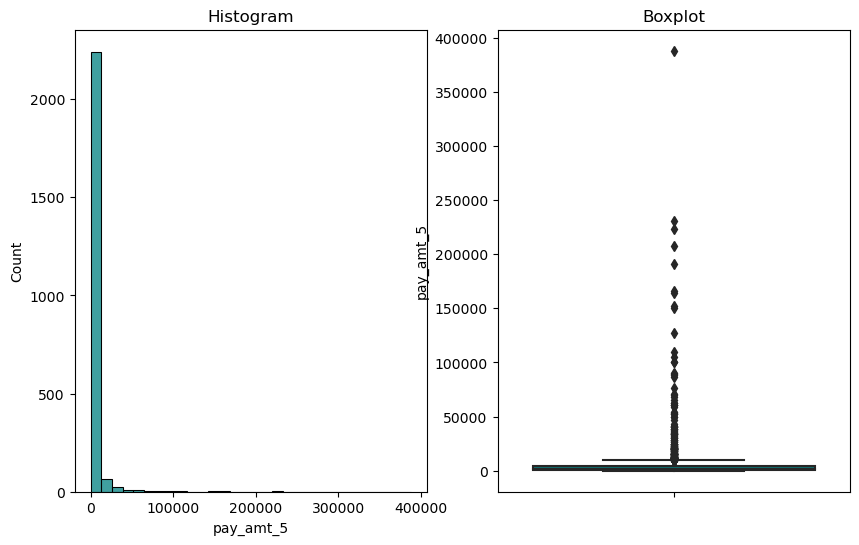


pay_amt_5 - After Capping


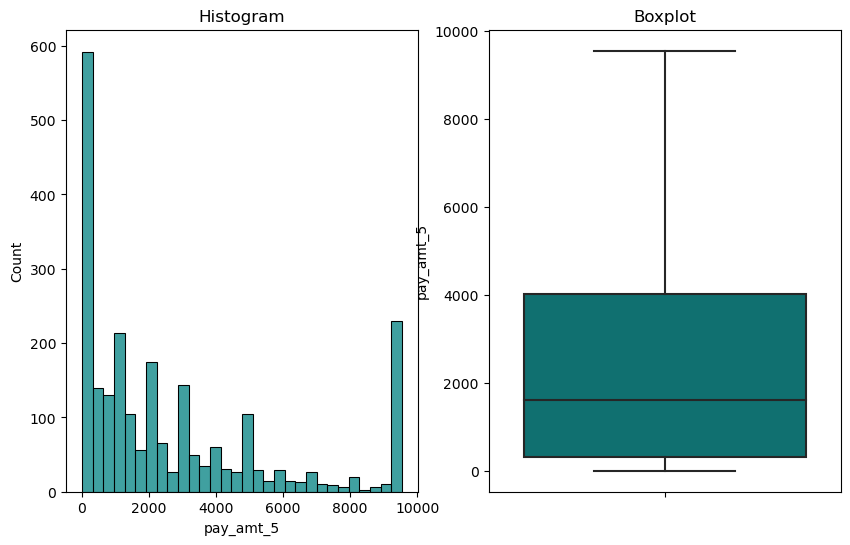

pay_amt_6 - Before Capping


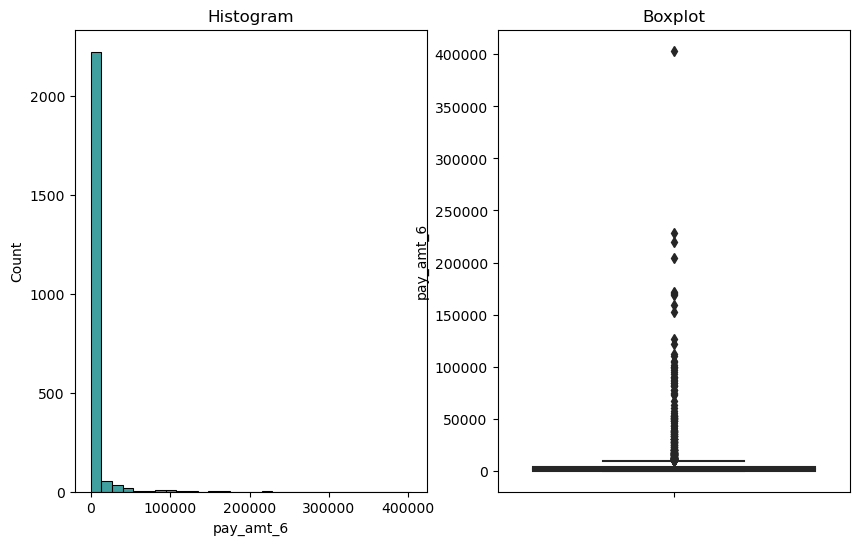


pay_amt_6 - After Capping


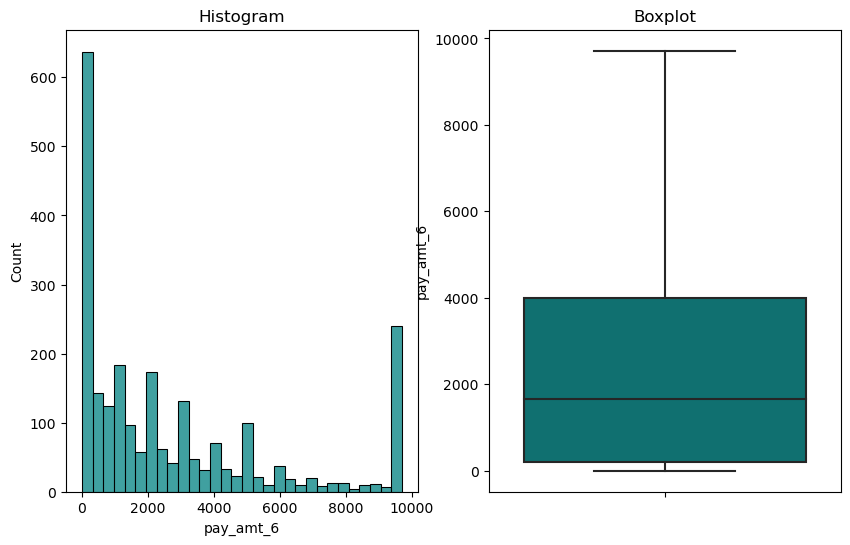

In [16]:
# Plotting histogram and boxplot before and after capping
for col in list_num:
  print(f'{col} - Before Capping')
  diagnostic_plots(X_train, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(X_train_capped, col)


### Setelah di handling, nampak bahwa seluruh data sudah tidak memiliki outliers, hal ini bisa dilihat dari hasil boxplot sesudah di handling. namum pada sebaran datanya, nampak setelah di handling, sebaran datanya masih berdistribusi skew, hanya kolom pay_0, pay_1, pay_2, pay_3, pay 4, pay 5 yang berdistribusi normal

## **Missing Value**

### Selanjutnya kita akan memeriksa Missing Value pada setiap variabel, missing value bisa menyebabkan kegagalan dalam melakukan train model nantinya

In [17]:
#Mencari Mssing Value pada X_train
null_values = X_train_capped.isnull()
null_count = null_values.sum()
print(null_count)

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64


In [18]:
#Mencari Missing Values pada X_test

null_values = X_test.isnull()
null_count = null_values.sum()
print(null_count)

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64


In [19]:
#Mencari Missing Values pada y_train

null_values = y_train.isnull()
null_count = null_values.sum()
print(null_count)

0


In [20]:
#Mencari Missing Values pada y_test

null_values = y_test.isnull()
null_count = null_values.sum()
print(null_count)

0


### Setelah dilakukan analisa, nampak pada X_train dan X_test tidak memiliki missing value pada data mereka

## **Feature Selection**

### Setelah melakukan pengecekan missing value, selanjutnya kita akan memili kolom fitur yang mempunyai hubungan dengan kolom target. karena kolom target kita mempunyai nilai yang biner, maka akan digunkan uji point biserial untuk kolom fitur yang kontinu dan akan menggunakan chi squared untuk kolom fitur yang tidak kontinu

### Pertama-kita akan memecah data menjadi kontinu dan tidak

In [21]:
#Membuat fungsi untuk mengambil kolom yang kontinu
exclude_columns = ['sex', 'education_level', 'marital_status']
list_kontinu = [col for col in X_train_capped.columns if col not in exclude_columns]
X_train_capped_kontinu = X_train_capped.drop(columns=exclude_columns, axis =1)  # Menggunakan 'columns' di drop dan memberikan daftar kolom yang ingin dihapus
X_train_capped_non_kontinu = X_train_capped.drop(columns = list_kontinu, axis =1)


In [22]:
#menginisiasi list kosong
p_values = []
interpretation = []
cols = []
corr = []

for col in X_train_capped_kontinu:
    corr_coef, p_value = pointbiserialr(X_train_capped_kontinu[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    if p_value < 0.05:
        interpretation.append('Significant Correlation')
    else:
        interpretation.append('No Significant Correlation')

# Create DataFrame with all numeric values
correlation_df = pd.DataFrame({
    'Column Name': cols,
    'Correlation Coefficient': corr,
    'P-value': p_values
})

# Add 'Interpretation' column with interpretation values
correlation_df['Interpretation'] = interpretation

correlation_df

,Column Name,Correlation Coefficient,P-value,Interpretation
0,limit_balance,-0.159188,6.257272e-15,Significant Correlation
1,age,0.011078,5.897186e-01,No Significant Correlation
2,pay_0,0.307595,3.737485e-53,Significant Correlation
3,pay_2,0.252544,7.821060e-36,Significant Correlation
4,pay_3,0.229397,1.072289e-29,Significant Correlation
5,pay_4,0.217966,6.645616e-27,Significant Correlation
6,pay_5,0.202227,2.602778e-23,Significant Correlation
7,pay_6,0.194951,9.535701e-22,Significant Correlation
8,bill_amt_1,-0.010214,6.190275e-01,No Significant Correlation
9,bill_amt_2,-0.001945,9.245811e-01,No Significant Correlation


### Dari hasil analisis, diketahui bahwa fitur age, dan bil_amt_1-6 tidak memiliki korelasi yang kuat dengan kolom target sehingga kolom tersebut akan di drop demi menjaga performa model

In [23]:
p_values = []
interpretation = []
cols = []
corr = []

# Buat tabel kontingensi
contingency_table = pd.crosstab(X_train_capped['sex'], X_train_capped['education_level'])

# Hitung chi-squared statistic
chi2, p_value, _, _ = chi2_contingency(contingency_table)

for col in X_train_capped_non_kontinu:
    contingency_table = pd.crosstab(X_train_capped[col], y_train)

    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    p_values.append(p_value)
    cols.append(col)
    corr.append(chi2)

    if p_value < 0.05:
        interpretation.append('Significant Correlation')
    else:
        interpretation.append('No Significant Correlation')

# Create DataFrame with all numeric values
correlation_df = pd.DataFrame({
    'Column Name': cols,
    'chi-squred Coefficient': corr,
    'P-value': p_values
})

# Add 'Interpretation' column with interpretation values
correlation_df['Interpretation'] = interpretation

correlation_df

,Column Name,chi-squred Coefficient,P-value,Interpretation
0,sex,1.079801,0.298742,No Significant Correlation
1,education_level,21.638151,0.000237,Significant Correlation
2,marital_status,2.804294,0.422794,No Significant Correlation


### Dari hasil analisis, diketahui bahwa fitur sex, dan martial_status tidak memiliki korelasi yang kuat dengan kolom target sehingga kolom tersebut akan di drop demi menjaga performa model

In [84]:
#Mendefiniskan kolom yang akan di drop
columns_to_drop = ['sex', 'marital_status', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4','bill_amt_5', 'bill_amt_6', 'age']
#melakukan drop kolom pada X_train dan X_test
X_train_select = X_train_capped.drop(columns=columns_to_drop, axis=1)
X_test_select = X_test_capped.drop(columns=columns_to_drop, axis=1)


## **Encoding**

#### Pada feature selection kali ini kita tidak melakukan encoding karena tidak terdapat data yang bertipe string atau tipe kategori lainnya.

## **Scalling**

#### Selanjutnya kita akan melakukan scalling untuk menyamakan rentang data pada kolom fitur dan test nya. tapi sebelumnya kita akan melihat sebaran datanya untuk mengetahui jenis scalling apa yang cocok digunakan pada scalling kali ini

In [85]:
#mendefinisikan kolom yang digunakan dan list tempat value skewness
df_num = X_train_select
nilai_skew = []
nilai_skew_normal = []

#membuat fungsi untuk memetakan distribusi setiap kolom
for i in df_num.columns:
    skewness = X_train_select[i].skew()
    if -0.5 <= skewness <= 0.5:
        nilai_skew_normal.append(i)
    else:
        nilai_skew.append(i)

# Menampilkan list
print('kolom yang mempunyai nilai skewness sedang:', nilai_skew)
print('kolom yang mempunyai nilai skewness normal:', nilai_skew_normal)

kolom yang mempunyai nilai skewness sedang: ['limit_balance', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
kolom yang mempunyai nilai skewness normal: ['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


Untuk kolom yang memliki distribusi normal, kita akan melakukan standar scalling, sedangkan untuk nilai yang memiliki skew distribution, kita akan gunakan Robust scalling

In [86]:
#melakukan scalling menggunakan standard scaller
standard_scaler = StandardScaler()
standard_scaler.fit(X_train[nilai_skew_normal])
X_train_select[nilai_skew_normal] = standard_scaler.transform(X_train_select[nilai_skew_normal])
X_test_select[nilai_skew_normal] = standard_scaler.transform(X_test_select[nilai_skew_normal])

In [87]:
#melakukan scalling menggunakan robust scaller
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[nilai_skew])
X_train_select[nilai_skew] = robust_scaler.transform(X_train_select[nilai_skew])
X_test_select[nilai_skew] = robust_scaler.transform(X_test_select[nilai_skew])

Membuat dataframe baru hasil dari scalling sebagai X_train_final dan X_test_final

In [88]:
X_train_final = X_train_select
X_test_final = X_test_select

# **Model Defition**

Logistic Regression adalah model yang digunakan untuk memprediksi probabilitas  yang terjadi atau tidak terjadi dengan menggunakan satu atau lebih variabel independen. Parameter-parameter yang digunakan adalah:

- **C**: Kebalikan dari kekuatan regularisasi. Nilai yang lebih kecil menghasilkan regularisasi yang lebih kuat.
- **solver**: Algoritma yang digunakan untuk menemukan parameter model, seperti 'liblinear', 'sag', 'lbfgs', dll.
- **max_iter**: Jumlah iterasi maksimum yang akan dieksekusi oleh solver.

K-Nearest Neighbors (kNN) adalah algoritma machine learning yang sederhana dan intuitif yang digunakan untuk klasifikasi dan regresi. Parameter-parameter yang digunakan adalah:

- **n_neighbors**: Jumlah tetangga yang akan dilihat.
- **weights**: Skema yang digunakan dalam perhitungan, seperti 'uniform' (semua tetangga memiliki bobot yang sama) atau 'distance' (tetangga yang lebih dekat memiliki bobot yang lebih besar).
- **leaf_size** = leaf size dapat mempengaruhi kecepatan konstruksi dan query, serta memori yang dibutuhkan untuk menyimpan pohon. Nilai optimal tergantung pada sifat masalahnya

Support Vector Machine (SVM) adalah algoritma machine learning yang dapat digunakan untuk tugas klasifikasi dan regresi. Parameter-parameter yang digunakan adalah:

- **C**: Parameter penalti untuk kesalahan klasifikasi.
- **kernel**: Jenis kernel yang akan digunakan, seperti 'linear', 'rbf' (Gaussian), 'poly' (polinomial), atau 'sigmoid'.
- **gamma**: Koefisien kernel untuk 'rbf', 'poly', dan 'sigmoid'. Semakin besar nilainya, semakin sempit lekukan kernel.

ROC-AUC Score menunjukan performa dari binary klasifikasi dengan decision threshold yang berbeda. Karena pada data, kita melakukan modeling untuk kolom target yang memiliki 2 nilai (biner) sehingga ROC-AUC Score sangat cocok digunakan untuk mengevaluasi kinerja model.

# **Model Training** & **Model Evaluation**

Pada model training kali ini akan dilakukan dengan model dasar atau model default pada sklern kemudian akan dibandingkan hasil evaluasi modelnya

In [89]:
# Define models
logreg = LogisticRegression()
svc = SVC()
kNN = KNeighborsClassifier()
models = {
    'Logistic Regression': logreg,
    'Super Vector Classifier': svc,
    'Kneighbors Classifier': kNN,
}

In [90]:
# Initialize DataFrame to store ROC-AUC Score for training and testing
df_model = pd.DataFrame(columns=models.keys(), index=['Training ROC-AUC Score', 'Testing ROC-AUC Score'])

# Loop over models to calculate ROC-AUC Score for both training and testing
for model_name, model in models.items():

    #Fit model
    model. fit(X_train_final, y_train)
    # Calculate ROC-AUC Score for training data

    y_train_pred = model.predict(X_train_final)
    training_f1 = roc_auc_score(y_train, y_train_pred)

    # Calculate ROC-AUC Score for testing data
    y_test_pred = model.predict(X_test_final)
    testing_f1 = roc_auc_score(y_test, y_test_pred)

    # Store ROC-AUC Score in DataFrame
    df_model.loc['Training ROC-AUC Score', model_name] = training_f1
    df_model.loc['Testing ROC-AUC Score', model_name] = testing_f1

df_model

,Logistic Regression,Super Vector Classifier,Kneighbors Classifier
Training ROC-AUC Score,0.615527,0.679058,0.711449
Testing ROC-AUC Score,0.665363,0.701159,0.668953


dari hasil evaluasi model, didapatkan bahwa:
- Logistic Regression  menunjukkan bahwa model cenderung sedikit overfitting pada data train, tetapi masih mampu menggeneralisasi dengan baik pada data test.
- Support Vector Classifier menunjukkan bahwa model SVM cenderung memberikan kinerja yang lebih baik dan lebih stabil pada kedua set data.
- K-Nearest Neighbors Classifier menunjukkan bahwa model KNN mungkin sedikit overfitting pada data train dan tidak tergeneralisasi dengan baik pada data test.

sehingga dari ketiga model tersebut, model Support Vector Classifier tampaknya memberikan kinerja yang lebih baik pada data uji.

Kemudian kita akan melihat kekonsistenan performa model menggunakan cros validation. dan karena kita memliki data data yang imbalanced, menggunakan cross validation biasa akan membuat validasi yang dilakukan tidak adil, sehingga akan dilakukan stratified fold agar validasi yang dilakukan adil

#### Untuk model train

In [91]:
skfold = StratifiedKFold(n_splits=5)

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_final, y_train, cv=skfold, scoring="roc_auc")

    print('Model:', model_name)
    print('ROC-AUC Scores - Cross Validation: ', scores)
    print('ROC-AUC Mean Score - Cross Validation: ', scores.mean())
    print('ROC-AUC Std Deviation - Cross Validation: ', scores.std())
    print('ROC-AUC Range of Test-Set: ', (scores.mean() - scores.std()), '-', (scores.mean() + scores.std()))
    print('-'*10)


Model: Logistic Regression
ROC-AUC Scores - Cross Validation:  [0.75495453 0.7502497  0.7357524  0.69255169 0.71232606]
ROC-AUC Mean Score - Cross Validation:  0.7291668752762819
ROC-AUC Std Deviation - Cross Validation:  0.023567528791950027
ROC-AUC Range of Test-Set:  0.7055993464843319 - 0.7527344040682319
----------


Model: Super Vector Classifier
ROC-AUC Scores - Cross Validation:  [0.77503548 0.73248173 0.73426592 0.67320097 0.71092926]
ROC-AUC Mean Score - Cross Validation:  0.7251826732558538
ROC-AUC Std Deviation - Cross Validation:  0.033245576700060696
ROC-AUC Range of Test-Set:  0.6919370965557932 - 0.7584282499559145
----------
Model: Kneighbors Classifier
ROC-AUC Scores - Cross Validation:  [0.72677811 0.69774746 0.71072121 0.64714782 0.65741619]
ROC-AUC Mean Score - Cross Validation:  0.6879621594918139
ROC-AUC Std Deviation - Cross Validation:  0.030722208540172748
ROC-AUC Range of Test-Set:  0.6572399509516412 - 0.7186843680319867
----------


Dari hasil cross validation diatas didapati bahwa:
- Semua tiga model memiliki kinerja yang cukup baik, dengan ROC-AUC Score di atas 0.5, yang menunjukkan bahwa model-model tersebut dapat membedakan antara kelas positif dan negatif.
- Model Logistic Regression memiliki rata-rata ROC-AUC tertinggi dengan 0.73, diikuti oleh Support Vector Classifier dengan 0.728, dan terakhir K-Nearest Neighbors dengan 0.6845.
- Meskipun demikian, perlu dicatat bahwa perbedaan antara rata-rata ROC-AUC tidak terlalu besar di antara model-model tersebut.

#### Untuk data Test

In [92]:
skfold = StratifiedKFold(n_splits=5)

for model_name, model in models.items():
    scores = cross_val_score(model, X_test_final, y_test, cv=skfold, scoring="roc_auc")

    print('Model:', model_name)
    print('ROC-AUC Scores - Cross Validation: ', scores)
    print('ROC-AUC Mean Score - Cross Validation: ', scores.mean())
    print('ROC-AUC Std Deviation - Cross Validation: ', scores.std())
    print('ROC-AUC Range of Test-Set: ', (scores.mean() - scores.std()), '-', (scores.mean() + scores.std()))
    print('-'*10)


Model: Logistic Regression
ROC-AUC Scores - Cross Validation:  [0.76425532 0.79611249 0.81968569 0.75741935 0.79612903]
ROC-AUC Mean Score - Cross Validation:  0.786720377312004
ROC-AUC Std Deviation - Cross Validation:  0.02292018849057295
ROC-AUC Range of Test-Set:  0.763800188821431 - 0.8096405658025769
----------
Model: Super Vector Classifier
ROC-AUC Scores - Cross Validation:  [0.82212766 0.77874276 0.7688172  0.76645161 0.81204301]
ROC-AUC Mean Score - Cross Validation:  0.7896364500290376
ROC-AUC Std Deviation - Cross Validation:  0.023010357458856826
ROC-AUC Range of Test-Set:  0.7666260925701808 - 0.8126468074878944
----------
Model: Kneighbors Classifier
ROC-AUC Scores - Cross Validation:  [0.83255319 0.77564103 0.74400331 0.76107527 0.7427957 ]
ROC-AUC Mean Score - Cross Validation:  0.7712136986783521
ROC-AUC Std Deviation - Cross Validation:  0.03296334450565626
ROC-AUC Range of Test-Set:  0.7382503541726958 - 0.8041770431840084
----------


Dari hasil cross validation pada data test diatas didapati beberapa hal yang sama yakni:
- Semua tiga model memiliki kinerja yang cukup baik, dengan ROC-AUC Score di atas 0.5, yang menunjukkan bahwa model-model tersebut dapat membedakan antara kelas positif dan negatif.
- Model Support Vector Classifier memiliki rata-rata ROC-AUC tertinggi dengan 0.788, diikuti oleh Logistic Regression dengan 0.785, dan terakhir K-Nearest Neighbors dengan 0.7497.
- Meskipun demikian, perlu dicatat bahwa perbedaan antara rata-rata ROC-AUC tidak terlalu besar di antara model-model tersebut.

### walaupun diindikasikan ada overfitting pada setiap model Dari hasil analisis menggunakan cross validation, tetapi logistic regression lebih stabil dimana nilai train dan test nya lebih dekat satu sama lain dibanding model lainnya 

# **Model Tuning**

Setelah kita melakukan modelling dengan model default pada setiap model klasifikasi, selanjutnya kita akan melakukan modelling menggunakan hyperparameter yang sudah didefiniskan pada model definisi diatas dan akan langsung dicari model terbaiknya menggunakan metode **random search** dan **grid search** dan kemudian akan kita bandingkan hasilnya dengan hasil pada model deafult

### **Random Search**

In [93]:
# Mendefinisikan Hyperparameters untuk model Logreg
logreg_param = []
C = [x for x in np.linspace(start=0.1, stop=50, num = 3)]
solver = ['lbfgs', 'liblinear', 'newton-cg']
max_iter = [int(x) for x in np.linspace(100, 2000, num=5)]
logreg_param  = {       'C':C,
                        'solver':solver,
                        'max_iter':max_iter,
                        }
#Mendefinisikan Hyperparameters untuk model kNN
kNN_params = []
n_neighbors = [int(x) for x in np.linspace(start=1, stop=100, num = 10)]
weights = ['uniform', 'distance']
leaf_size = [int(x) for x in np.linspace(start=1, stop=500, num = 50)]
kNN_params = {'n_neighbors': n_neighbors,
                        'weights':weights,
                        'leaf_size':leaf_size,
                        
                        }
# Define Hyperparameters
svc_params = []
kernel = ['linear', 'poly', 'rbf']
C = [x for x in np.linspace(start=0.1, stop=50, num = 3)]
gamma = ['auto','scale']
#class_weight = ['dict', 'balanced', 'none']
svc_params = {'kernel': kernel,
                        'C':C,
                        'gamma':gamma,
                        #'class_weight':class_weight
                        }

rndm_params = {
    'LogReg_Params': logreg_param,
    'SVC_Params': svc_params,
    'kNN_Params': kNN_params
}

In [94]:
rndm_model = pd.DataFrame(columns=rndm_params.keys(), index=['Training ROC-AUC Score', 'Test ROC-AUC Score'])

# Melakukan loop untuk melakukan pemodelan dan mengevaluasi menggunakan ROC-AUC Score untuk training and testing
for param_name, params in rndm_params.items():
    if param_name == 'LogReg_Params':
        model = LogisticRegression()
    elif param_name == 'SVC_Params':
        model = SVC()
    elif param_name == 'kNN_Params':
        model = KNeighborsClassifier()
    else:
        raise ValueError(f"Unknown model parameter: {param_name}")

    rndm_search = RandomizedSearchCV(estimator=model,
                                     param_distributions=params,
                                     n_iter=50,
                                     cv=5,
                                     verbose=2,
                                     random_state=42,
                                     n_jobs=-1,
                                     scoring='roc_auc')
    rndm_search.fit(X_train_final, y_train)

    # Mengkalkulasi ROC-AUC Score untuk training data
    y_train_pred = rndm_search.best_estimator_.predict(X_train_final)
    training_roc_auc = roc_auc_score(y_train, y_train_pred)

    # Mengkalkulasi ROC-AUC Score untuk testing data
    y_test_pred = rndm_search.best_estimator_.predict(X_test_final)
    testing_roc_auc = roc_auc_score(y_test, y_test_pred)

    # Menyimpan ROC-AUC Score di DataFrame
    rndm_model.loc['Training ROC-AUC Score', param_name] = training_roc_auc
    rndm_model.loc['Test ROC-AUC Score', param_name] = testing_roc_auc

#Meanggil DafaFrame nilai ROC-AUC Score
rndm_model

c:\Users\62822\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 45 is smaller than n_iter=50. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 45 candidates, totalling 225 fits


c:\Users\62822\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


,LogReg_Params,SVC_Params,kNN_Params
Training ROC-AUC Score,0.614632,0.609349,0.615973
Test ROC-AUC Score,0.649615,0.631003,0.642814


#### Dari hasil pemodelan menggunakan parameter yang telah ditunning menggunakan Random Search didati bahwa nilai evaluasi ROC-AUC Score nya lebih rendah dari nilai base modelnya. namun jarak antara nilai test dan train pada model yang telah dituning lebih dekat dibandingkan pada base model sehingga bisa dikatakan bahwa model yang telah ditunning stabil (tidak terlalu mengalami overfitting ) namum nilai evaluasinya cukup jauh dibandingkan dengan base model. Kemudian didapati bahwa model SVC lebih baik dimana nilai dari train dan testnya hampir mirip satu sama lain dibandingkan model lainnya walaupun memiliki nilai ROC-AUC Score yang lebih rendah

## **Grid Search**

In [95]:
# Mendefinisikan Hyperparameters untuk model Logreg
logreg_param = []
C = [x for x in np.linspace(start=0.1, stop=50, num = 3)]
solver = ['lbfgs', 'liblinear', 'newton-cg']
max_iter = [int(x) for x in np.linspace(100, 2000, num=5)]
logreg_param  = {       'C':C,
                        'solver':solver,
                        'max_iter':max_iter,
                        }
#Mendefinisikan Hyperparameters untuk model kNN
kNN_params = []
n_neighbors = [int(x) for x in np.linspace(start=1, stop=100, num = 10)]
weights = ['uniform', 'distance']
leaf_size = [int(x) for x in np.linspace(start=1, stop=500, num = 50)]
kNN_params = {'n_neighbors': n_neighbors,
                        'weights':weights,
                        'leaf_size':leaf_size,
                        }
# Mendefinisikan Hyperparameters untuk model SVC
svc_params = []
kernel = ['linear', 'poly', 'rbf']
C = [x for x in np.linspace(start=0.1, stop=50, num = 3)]
gamma = ['auto','scale']
#class_weight = ['dict', 'balanced', 'none']
svc_params = {'kernel': kernel,
                        'C':C,
                        'gamma':gamma,
                        #'class_weight':class_weight
                        }

#Menyimpan nilai hyperparameter di dataframe
gridsrc_params = {
    'LogReg_Params': logreg_param,
    'SVC_Params': svc_params,
    'kNN_Params': kNN_params
}

In [96]:
gridsrc_model = pd.DataFrame(columns=gridsrc_params.keys(), index=['Training ROC-AUC Score', 'Test ROC-AUC Score'])

# Melakukan loop untuk melakukan pemodelan dan mengevaluasi menggunakan ROC-AUC Score untuk training and testing
for param_name, params in gridsrc_params.items():
    if param_name == 'LogReg_Params':
        model = LogisticRegression()
    elif param_name == 'SVC_Params':
        model = SVC()
    elif param_name == 'kNN_Params':
        model = KNeighborsClassifier()
    else:
        raise ValueError(f"Unknown model parameter: {param_name}")

    gridsrc_search = GridSearchCV(estimator=model,
                                  param_grid=params,
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1,
                                  scoring='roc_auc')
    gridsrc_search.fit(X_train_final, y_train)

    # Mengkalkulasi ROC-AUC Score untuk training data
    y_train_pred = gridsrc_search.best_estimator_.predict(X_train_final)
    training_roc_auc = roc_auc_score(y_train, y_train_pred)

    # Mengkalkulasi ROC-AUC Score untuk testing data
    y_test_pred = gridsrc_search.best_estimator_.predict(X_test_final)
    testing_roc_auc = roc_auc_score(y_test, y_test_pred)

    # Menyimpan ROC-AUC Score di DataFrame
    gridsrc_model.loc['Training ROC-AUC Score', param_name] = training_roc_auc
    gridsrc_model.loc['Test ROC-AUC Score', param_name] = testing_roc_auc

#Meanggil DafaFrame nilai ROC-AUC Score
gridsrc_model

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


,LogReg_Params,SVC_Params,kNN_Params
Training ROC-AUC Score,0.614632,0.609349,0.615973
Test ROC-AUC Score,0.649615,0.631003,0.642814


### Hasil tunning dengan grid scearh hampir sama dengan dengan Random search sehingga kesimpulan yang didapat juga tidak terlalu berbeda dimana nilai evaluasi ROC-AUC Score nya lebih rendah dari nilai base modelnya. namun jarak antara nilai test dan train pada model yang telah dituning lebih dekat dibandingkan pada base model sehingga bisa dikatakan bahwa model yang telah ditunning stabil (tidak terlalu mengalami overfitting ) namum nilai evaluasinya cukup jauh dibandingkan dengan base model. Kemudian didapati bahwa model SVC lebih baik dimana nilai dari train dan testnya hampir mirip satu sama lain dibandingkan model lainnya walaupun memiliki nilai ROC-AUC Score yang lebih rendah

### Sehingga dapat disimpulakn bahwa tunning model mengguna grid search atau random search pada data ini menggunakan parameter yang sama akan mendapatkan nilai yang hampir sama juga. Jauhnya perbandingan nilai ROC-AUC pada model base dan setelah ditunning sehingga kita akan menggunakan model base saja pada saat melakukan deployment nanti.

# **Save Model**

Untuk memudahkan kita dalam menggunakan model machine learning dan feature engineering yang sudah dibuat, berikutnya kita akan simpan menggunakan joblib agar nanti pada suatu saat kita membutuhnya, kita bisa langsung menggunakannya

In [97]:
#save mode
with open('model_logreg.pkl', 'wb') as file1:
  joblib.dump(logreg,file1)

with open('model_svc.pkl', 'wb') as file2:
  joblib.dump(svc,file2)

with open('model_svc.pkl', 'wb') as file3:
  joblib.dump(kNN,file3)

#save robust scaller
with open('robust_scaler.pkl', 'wb') as file4:
  joblib.dump(robust_scaler,file4)

with open('standard_scaler.pkl', 'wb') as file5:
  joblib.dump(standard_scaler,file5)

#save skew capping
with open('winsoriserskew.pkl', 'wb') as file6:
  joblib.dump(winsoriserskew,file6)


# **Model Inference**

Model akan dicoba untuk melakukan prediksi dengan data baru yang belum perna di training sebelumnya

In [101]:
data_inf = {
    'limit_balance': [75000,110000],
    'education_level' : [4, 3],
    'pay_0': [0, 1],
    'pay_2': [0, 0],
    'pay_3': [0, 0],
    'pay_4': [0, 0],
    'pay_5': [0, 0],
    'pay_6': [0, 0],
    'pay_amt_1': [2000, 4000],
    'pay_amt_2': [2500, 1000],
    'pay_amt_3': [1000, 4500],
    'pay_amt_4': [20, 1456],
    'pay_amt_5': [200, 0],
    'pay_amt_6': [2000, 4000],
}
df_inf =pd.DataFrame(data_inf)
df_inf

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,75000,4,0,0,0,0,0,0,2000,2500,1000,20,200,2000
1,110000,3,1,0,0,0,0,0,4000,1000,4500,1456,0,4000


Melakukan load dari model yang sudah disaving, untuk mengetest sejauh mana model bisa melakukan prediksi dengan akurat. pada data ini akan digunakan model logistic regression karena memiliki nilai evaluasi yang paling baik

In [102]:
#save mode
with open('model_logreg.pkl', 'rb') as file1:
  logreg=joblib.load(file1)

In [103]:
pred_inf = logreg.predict(df_inf)
pred_inf

array([0, 0], dtype=int64)

Maka dengan data inferential yang di input, didapati bahwa prediksi untuk nilai pembayaran bulan berikutnya adalah:
1. 0 (tidak membayar)
2. 0 (tidak membayar)

# **Kesimpulan**

Dari seluruh proses pembuatan machine learning untuk memperkirakan apakah pengguna harus membayar tagihan dibulan berikutnya atau tidak dengan kolom fitur yang ada pada dataset. Dilakukan pemodelan dengan Logistic Regression, Super Vector Classifier, dan K-Neighbors Classifier. Kemudian digunakan ROC-AUC Score sebagai metrik evaluasi karena kolom target mempunyai nilai yang biner dan data nya tidak seimbang, selanjutnya didapat nilai terbaik pada train dan test pada model Logisti Regression yaitu  0.7291668752762819 dari train dan 0.786720377312004 untuk test. Sedangkan untuk model SVC memiliki nilai yang hampir mirip dengan Logistic Regression namum memiliki rentang nilai train dan test yang lebih jauh dari Logistic Regression, sementara K-Neighbors Classifier lebih rendah dari kedua model lainnya dan memiliki rentang yang labih jauh. kemudian setelah di tunning menggunakan Random dan Grid search kemudian didapat nilai ROC-AUC yang lebih kecil dari model base tetapi rentang nilainya lebih kecil dekat dari model base. Namun, karena nilai ROC-AUC nya terlalu rendah jauh dari base model, sehingga digunakan model base.

**Conseptual Problems**

1. Apakah yang dimaksud dengan coeficient pada logistic Regression?

Answer: coeficient pada Logistic Regression menurut (Alan Agresti, 2019) merupakan nilai dari log rasio peluang (odds-ratio). coeficient ini dapat menunjukkan seberapa besar pengaruh setiap fitur terhadap probabilitas bahwa sampel akan termasuk dalam kelas yang ditentukan. 

2. Apakah fungsi parameter kernel pada SVM?

Answer : Merupakan jenis (parameter) yang digunakan untuk menentukan *pemisahan bagaimana yang 
digunakan dalam mengklasifikasikan dataset secara lebih efektif. 

3. Bagaimana cara memilih K yang optimal pada KNN ?

Answer : Kita dapat menggunakan metode Model Tunning, pada metode tersebut, akan cari nilai K yang menghasilkan performa model yang paling optimal. metode tunning tersebut yaitu Grid Search atau Random Search

4. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

Answer : 
- Accuracy dihitung dengan membagi jumlah prediksi yang benar (true positives) dengan jumlah total instance yang dievaluasi. Accuracy digunakan saat data yang kita punya imbang, atau balanced dataset.
- Precision adalah metrik yang menilai berapakali model menebak dengan tepat nilai dari True Positive. Precision digunakan saat kita ingin meminimalisir False Positive sekecil mungkin.
- Recall adalah metrik yang mengukur berapa sering model mengidentifikasi dengan benar True Positive dari seluruh Positive sampel. sama seperti Precision, Recall digunakan saat kita ingin meminimalisir False Positive sekecil mungkin
- F1 Score adalah metrik evaluasi yang umum digunakan dalam tugas klasifikasi untuk mengukur keseimbangan antara presisi (precision) dan recall. F1 score menggabungkan kedua metrik ini menjadi satu angka tunggal untuk memberikan gambaran yang lebih komprehensif tentang kinerja model klasifikasi. Berbeda dengan Accuracy, F1 Score Ini bekerja dengan baik untuk masalah dengan kelas yang tidak seimbang dan kelas yang seimbang.
